In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import numpy as np
import pandas as pd
from copy import deepcopy
from typing import List, Tuple, Dict, Callable
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import euclidean
from itertools import permutations, combinations
from joblib import load
import importlib

#from numba import jit, cuda

import tensorflow as tf

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from scipy.ndimage import rotate, shift

from sklearn.pipeline import Pipeline

# os.chdir('C:/Users/imke.bloemen/OneDrive - Accenture/1. Graduation/Code/NewCode/VAE_DBS/src')
# print(os.getcwd())

import VAE_DBS

from VAE_DBS.models.dice_gradients import DiceCounterfactual
from VAE_DBS.utils.utils import *
from VAE_DBS.data.load_data import *
from VAE_DBS.models.DiCE.dice_ml.utils.helpers import DataTransfomer
import random
import VAE_DBS.visualization.create_map_embedding as create_map_embedding
import VAE_DBS.visualization.create_map.create_map_UMAP_test_no_intermediate as create_map_UMAP_test_no_intermediate
# import ssnp_main.code.ssnp as ssnp
import VAE_DBS.models.transformers.ssnp

import skdim
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2


Num GPUs Available:  1


c:\Users\imke.bloemen\AppData\Local\anaconda3\envs\jan-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Step 1: Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

In [14]:
mnist_df = pd.DataFrame(mnist.data)

In [15]:
mnist_df['label'] = mnist.target

In [18]:
mnist_df['label'].dtype

CategoricalDtype(categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ordered=False)

In [20]:
mnist_df

pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel10  ...  pixel776  pixel777  pixel778  pixel779  pixel780  \
0          0.0  ...       0.0       0.0       0.0       0.0       0.0   
1          0.0  ...       0.0       0.0       0.0       0.0       0.0   
2          0.0  ...       0.0       0.0       0.0       0.0       0.0   
3          0.0  ...       0.0       0.0       0.0       0.0       0.0   
4          0.0  ...       0.0       0.0       0.0       0.0       0.0   
...        ...  ...       ...       ...       ...       ...       ...   
69995      0.0  ...       0.0       0.0       0.0       0.0       0.0   
69996      0.0  ...       0.0       0.0       0.0       0.0       0.0   
69997      0.0  ...       0.0       0.0       0.0       0.0       0.0   
69998      0.0  ...       0.0       0.0       0.0       0.0       0.0   
69999      0.0  ...       0.0       0.0       0.0       0.0       0.0   

       pixel781  pixel782  pixel783  pixel784  label  
0           0.0       0.0       0.0       0.0      5  
1           0.0       0.0       0.0       0.0      0  
2           0.0       0.0       0.0       0.0      4  
3           0.0       0.0       0.0       0.0      1  
4           0.0       0.0       0.0       0.0      9  
...         ...       ...       ...       ...    ...  
69995       0.0       0.0       0.0       0.0      2  
69996       0.0       0.0       0.0       0.0      3  
69997       0.0       0.0       0.0       0.0      4  
69998       0.0       0.0       0.0       0.0      5  
69999       0.0       0.0       0.0       0.0      6  

[70000 rows x 785 columns]

In [22]:
filtered_mnist = mnist_df[(mnist_df['label'].astype(int) == 3) | (mnist_df['label'].astype(int) == 5)]
filtered_mnist

pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
10        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
11        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
12        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69982     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69986     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69988     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel10  ...  pixel776  pixel777  pixel778  pixel779  pixel780  \
0          0.0  ...       0.0       0.0       0.0       0.0       0.0   
7          0.0  ...       0.0       0.0       0.0       0.0       0.0   
10         0.0  ...       0.0       0.0       0.0       0.0       0.0   
11         0.0  ...       0.0       0.0       0.0       0.0       0.0   
12         0.0  ...       0.0       0.0       0.0       0.0       0.0   
...        ...  ...       ...       ...       ...       ...       ...   
69982      0.0  ...       0.0       0.0       0.0       0.0       0.0   
69986      0.0  ...       0.0       0.0       0.0       0.0       0.0   
69988      0.0  ...       0.0       0.0       0.0       0.0       0.0   
69996      0.0  ...       0.0       0.0       0.0       0.0       0.0   
69998      0.0  ...       0.0       0.0       0.0       0.0       0.0   

       pixel781  pixel782  pixel783  pixel784  label  
0           0.0       0.0       0.0       0.0      5  
7           0.0       0.0       0.0       0.0      3  
10          0.0       0.0       0.0       0.0      3  
11          0.0       0.0       0.0       0.0      5  
12          0.0       0.0       0.0       0.0      3  
...         ...       ...       ...       ...    ...  
69982       0.0       0.0       0.0       0.0      5  
69986       0.0       0.0       0.0       0.0      3  
69988       0.0       0.0       0.0       0.0      5  
69996       0.0       0.0       0.0       0.0      3  
69998       0.0       0.0       0.0       0.0      5  

[13454 rows x 785 columns]

In [31]:
y = filtered_mnist['label'].astype(int).values
X = filtered_mnist.drop(columns=['label']).values

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [68]:
y_train = np.where(y_train == 3, 0, 1)
y_test = np.where(y_test == 3, 0, 1)

In [69]:
import joblib

# Fit only on X_train
scaler_standard = StandardScaler()
X_train_scaled = scaler_standard.fit_transform(X_train)
X_test_scaled = scaler_standard.transform(X_test)

pca = PCA(n_components=0.90)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Save the PCA model
joblib.dump(pca, '../models/transformers/projections/pca_model_mnist_filtered.pkl')

['../models/transformers/projections/pca_model_mnist_filtered.pkl']

In [70]:
data_columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]  # Column names for PCA components
data_columns.append('label')  # Add the class label column

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()
X_train = scaler_minmax.fit_transform(X_train_pca)
X_test = scaler_minmax.transform(X_test_pca)

In [72]:
y_train

array([0, 1, 0, ..., 1, 1, 0])

In [73]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
import os
from time import time

n_classes = 2
os.makedirs("../../../experiment_input/lamp/filtered_mnist_data_image_test/train_test_1/", exist_ok=True)
np.save("../../../experiment_input/lamp/filtered_mnist_data_image_test/train_test_1/X_train.npy", X_train)
np.save("../../../experiment_input/lamp/filtered_mnist_data_image_test/train_test_1/X_test.npy", X_test)
np.save("../../../experiment_input/lamp/filtered_mnist_data_image_test/train_test_1/y_train.npy", y_train)
np.save("../../../experiment_input/lamp/filtered_mnist_data_image_test/train_test_1/y_test.npy", y_test)

y_train_one_hot = to_categorical(y_train, num_classes=n_classes)
y_test_one_hot = to_categorical(y_test, num_classes=n_classes)

clf = Sequential([
                Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
                Dropout(0.2),
                Dense(512, activation='relu'),
                Dropout(0.2),
                Dense(512, activation='relu'),
                Dropout(0.2),
                Dense(n_classes, activation='softmax')  
            ])

start = time()
clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(
X_train, y_train_one_hot,
batch_size=64,
epochs=30,
validation_split=0.2)

output_dir = "../models/input_classifiers/evaluation/lamp"
dataset_name = "filtered_mnist_data_image_test"

loss, accuracy = clf.evaluate(X_test, y_test_one_hot, verbose=0)
# accuracy = clf.score(X_test, np.argmax(y_test_one_hot, axis=1))
# print(f"Accuracy on test data: {accuracy}")
print("\tAccuracy on test data: ", [loss, accuracy])
endtime = time() - start
save_path = os.path.join(output_dir, dataset_name)
os.makedirs(save_path, exist_ok=True)
with open(os.path.join(save_path, f"MLP_1.txt"), "w") as f:
    f.write(f"Accuracy on test data: {[loss, accuracy]}\n")
    f.write(f"Finished training classifier... {endtime}\n")
model_save_path = os.path.join(output_dir, dataset_name, f"MLP_1.h5")
# dump(clf, model_save_path)
clf.save(model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/30
135/135 [==============================] - 1s 5ms/step - loss: 0.5489 - accuracy: 0.6929 - val_loss: 0.2042 - val_accuracy: 0.9261
Epoch 2/30
135/135 [==============================] - 0s 3ms/step - loss: 0.2501 - accuracy: 0.8933 - val_loss: 0.2153 - val_accuracy: 0.9108
Epoch 3/30
135/135 [==============================] - 1s 4ms/step - loss: 0.2345 - accuracy: 0.9026 - val_loss: 0.1739 - val_accuracy: 0.9327
Epoch 4/30
135/135 [==============================] - 1s 4ms/step - loss: 0.2107 - accuracy: 0.9123 - val_loss: 0.2202 - val_accuracy: 0.9210
Epoch 5/30
135/135 [==============================] - 1s 4ms/step - loss: 0.2046 - accuracy: 0.9163 - val_loss: 0.2630 - val_accuracy: 0.8802
Epoch 6/30
135/135 [==============================] - 1s 4ms/step - loss: 0.1887 - accuracy: 0.9265 - val_loss: 0.1805 - val_accuracy: 0.9210
Epoch 7/30
135/135 [==============================] - 1s 4ms/step - loss: 0.2081 - accuracy: 0.9163 - val_loss: 0.1900 - val_accuracy: 0.9229
Epoch 

In [74]:
from sklearn.metrics import classification_report

print("Test Accuracy:", accuracy)
y_pred = np.argmax(clf.predict(X_test), axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9483463168144226
85/85 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1428
           1       0.92      0.97      0.95      1263

    accuracy                           0.95      2691
   macro avg       0.95      0.95      0.95      2691
weighted avg       0.95      0.95      0.95      2691



In [75]:
X_train.shape

(10763, 173)

In [77]:
total_cfs = 1
# num_iterations = 2
# uncertain_points = [9, 18, 22, 28, 71]
# num_samples = len(uncertain_points)*num_iterations
# samples = uncertain_points*num_iterations
num_samples = 68
dice_cf = DiceCounterfactual(dataset_name='filtered_mnist_data', 
                             data_columns=data_columns,
                             model_name='evaluation/lamp/filtered_mnist_data_image_test', 
                             outcome_name='label', 
                             preprocessing=None, 
                             backend='TF2', 
                             model_format='h5', 
                             multi_class=True, 
                             comparison=False,
                             comparison_method='train_test',
                             tt_number='1',
                             classifier_name='MLP',
                             comparison_data_name='filtered_mnist_data_image_test')

train_test
True
Epoch 1/50
38/38 [==============================] - 1s 8ms/step - loss: 0.6765 - val_loss: 0.4110
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 0.3123 - val_loss: 0.2439
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.2149 - val_loss: 0.1920
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1777 - val_loss: 0.1639
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1528 - val_loss: 0.1416
Epoch 6/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1320 - val_loss: 0.1222
Epoch 7/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1139 - val_loss: 0.1053
Epoch 8/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0980 - val_loss: 0.0905
Epoch 9/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0842 - val_loss: 0.0777
Epoch 10/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0722 - val_loss: 0.0666
Epo

In [80]:
path = '../../../experiment_output/lamp/filtered_mnist_data_image_test'
os.makedirs(path, exist_ok=True)

337/337 [==============================] - 1s 1ms/step
Mean Reconstruction MSE: 0.0017610979112235518
Mean Reconstruction MAE: 0.023754557694553927
Reconstruction samples saved
337/337 [==============================] - 0s 1ms/step
Latent space visualization saved
Reconstruction error plot saved
Correlation between original and reconstructed features saved


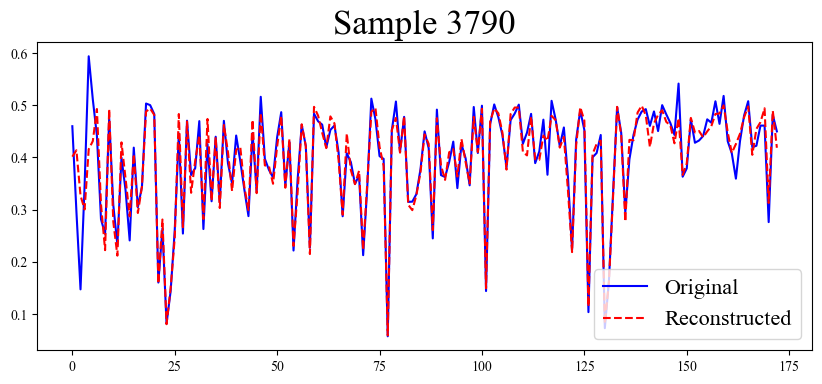

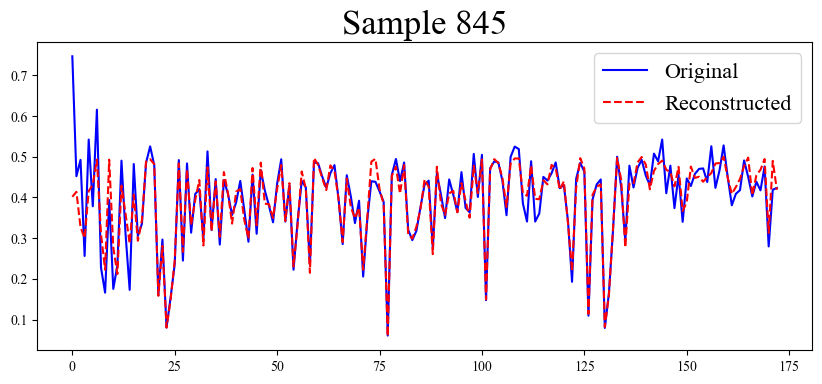

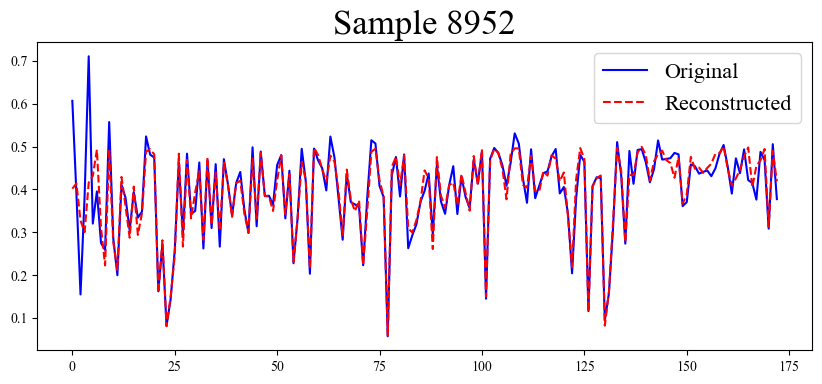

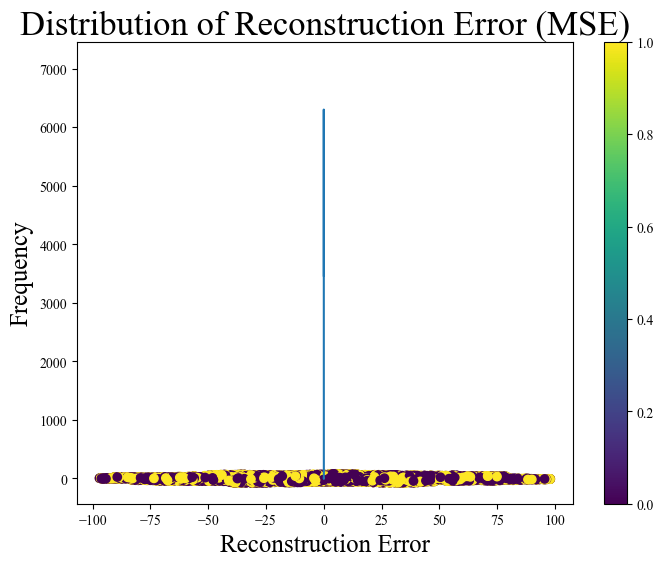

In [81]:
dice_cf.evaluate_autoencoder(save_path=path)

In [82]:
counterfactuals, dataset, predictions_dataset, intermediate_y_pred, dice_data, cf_points_binary, sampled_indices, sampled_predictions, intermediate_points, instance_interest_idxs, counterfactual_idxs, all_gradients, gradient_instance_interest_idxs, gradient_counterfactual_idxs, iterations, class_paths = dice_cf.fit_transform_all_gradient(num_samples=num_samples, 
                                                                                                                                                                                                                                                                                                                                                    total_cfs=total_cfs, 
                                                                                                                                                                                                                                                                                                                                                    desired_class='opposite', 
                                                                                                                                                                                                                                                                                                                                                    prediction_weight=1.5, 
                                                                                                                                                                                                                                                                                                                                                    ae_weight=0.5, 
                                                                                                                                                                                                                                                                                                                                                    proto_weight=0.7, 
                                                                                                                                                                                                                                                                                                                                                    samples=None, 
                                                                                                                                                                                                                                                                                                                                                    learning_rate=0.01,
                                                                                                                                                                                                                                                                                                                                                    min_iter=10)

337/337 [==============================] - 1s 2ms/step
Sampled indices: [ 3553  5857  9093  5872   416  7936  9980  5017  9772  2389  4232  5134
  2682  5898  7427  3545   569  8843  7766  1973  8353  1214  1786  2288
  5204  6743   526  7149  3181  8053  4011  6095 10419  5351 10729   585
  1830  6964  4173  8044  3297  7773  8599  1117  2815  4709   673  4879
  9110  3466  4719  9516  9077  3317  3835   173  8879  1869  5619   542
  4579  6702  6135  7030 10362  9767  2552  4920]
Processing #0 instance 3553... with prediction [9.9951673e-01 4.8329434e-04]
Generating counterfactuals for current class 0 and target class 1...
Generation of counterfactuals started...
Initial prediction for query instance: [0.73086846 0.2691315 ]
Target class defined: 1
step 1,  loss=1.96917
Converged because all CFs have reached the target class and probability.
Diverse Counterfactuals found! total time taken: 00 min 00 sec
Generation of counterfactuals completed.
Processing #1 instance 5857... with pred

In [83]:
_, model_for_predictions = load_model_dice('TF2', model_name='evaluation/lamp/filtered_mnist_data_image_test', tt_number='1', classifier_name='MLP', comparison_method_name=None)

None
True


In [84]:
dice_cf.save_data(path, version='1')

Original data saved to ../../../experiment_output/lamp/filtered_mnist_data_image_test\_original_1.csv
Counterfactuals saved to ../../../experiment_output/lamp/filtered_mnist_data_image_test\_counterfactuals_1.csv
Intermediate gradient points saved to ../../../experiment_output/lamp/filtered_mnist_data_image_test\_intermediate_gradients_1.csv
All gradients saved to ../../../experiment_output/lamp/filtered_mnist_data_image_test\_all_gradients_1.csv


In [85]:
predictions_dataset_output = [np.argmax(x) for x in predictions_dataset]
intermediate_y_pred_output = [np.argmax(x) for x in intermediate_y_pred]
pred_map = create_map_embedding.PredictionMap(grid_size=300, 
                                              original_data=dataset, 
                                              intermediate_gradient_points=intermediate_points, 
                                              counterfactuals=counterfactuals, 
                                              all_gradients=all_gradients, 
                                              number_of_neighbors=3, 
                                              model_for_predictions=model_for_predictions, 
                                            #   scaler_path_2D='../../../experiment_input/sdbm/hapiness/train_test_1/minmax_scaler_2D_MLP.save', 
                                              projection_method='lamp', 
                                              projection_name='filtered_mnist_data_image_test', 
                                              intermediate_predictions=np.array(intermediate_y_pred_output), 
                                              original_predictions=np.array(predictions_dataset_output), 
                                              counterfactual_predictions=np.array(cf_points_binary), 
                                              outcome_name='label', 
                                              n_classes=2, 
                                              version='MLP', 
                                              comparison=False,
                                              dataset_name='filtered_mnist_data_image_test',
                                              gradients=True)

colormap: <matplotlib.colors.ListedColormap object at 0x00000235A41F3520>


Lamp took 0:03:51.315035 to execute
Original data projected to 2D.
Grid created.
Plot saved as ../../../experiment_output/lamp/filtered_mnist_data_image_test\MLP_predicted_points.png.
Plot saved as ../../../experiment_output/lamp/filtered_mnist_data_image_test\MLP_original_data_points.png.


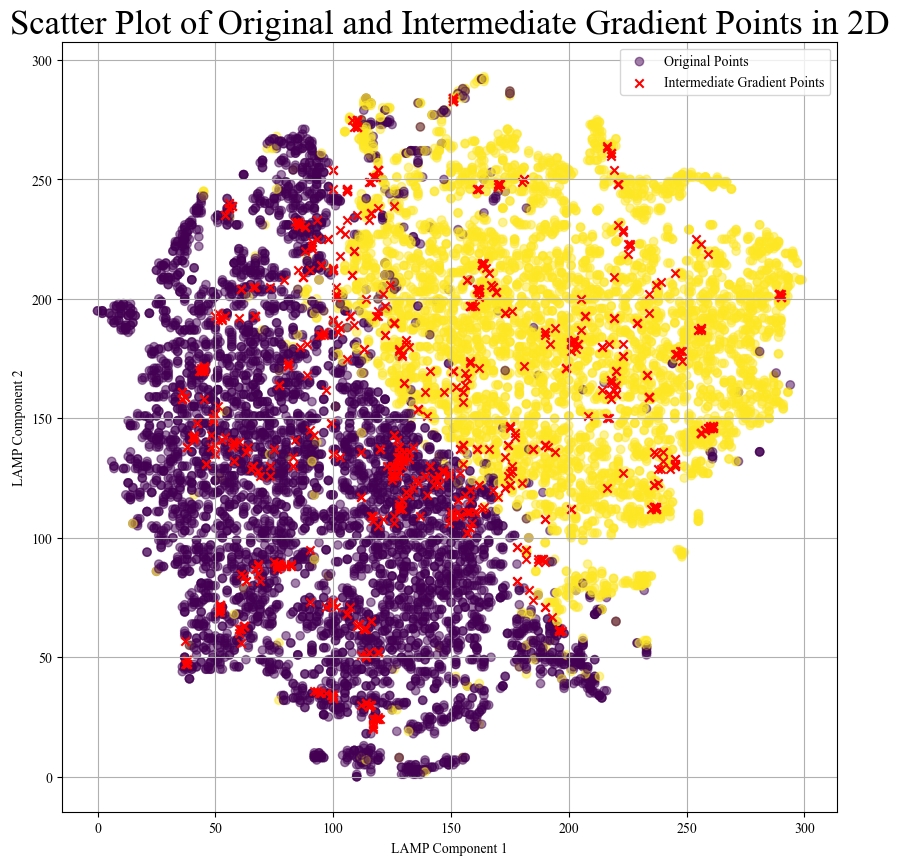

In [86]:
pred_map.fit_points_2D(path=path)

Constructing KDTree in LAMP space with combined data...
KDTree constructed.
4/4 [==============================] - 0s 2ms/step
Processed 0 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 1000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 2000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 3000 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 4000 / 90000 grid points.
4/4 [==============================] - 0s 3ms/step
Processed 5000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 6000 / 90000 grid points.
4/4 [==============================] - 0s 1ms/step
Processed 7000 / 90000 grid points.
4/4 [==============================] - 0s 0s/step
Processed 8000 / 90000 grid points.
4/4 [==============================] - 0s 2ms/step
Processed 9000 / 90000 grid points.
4/4 [==============================] - 0s 4ms/step
Processed 

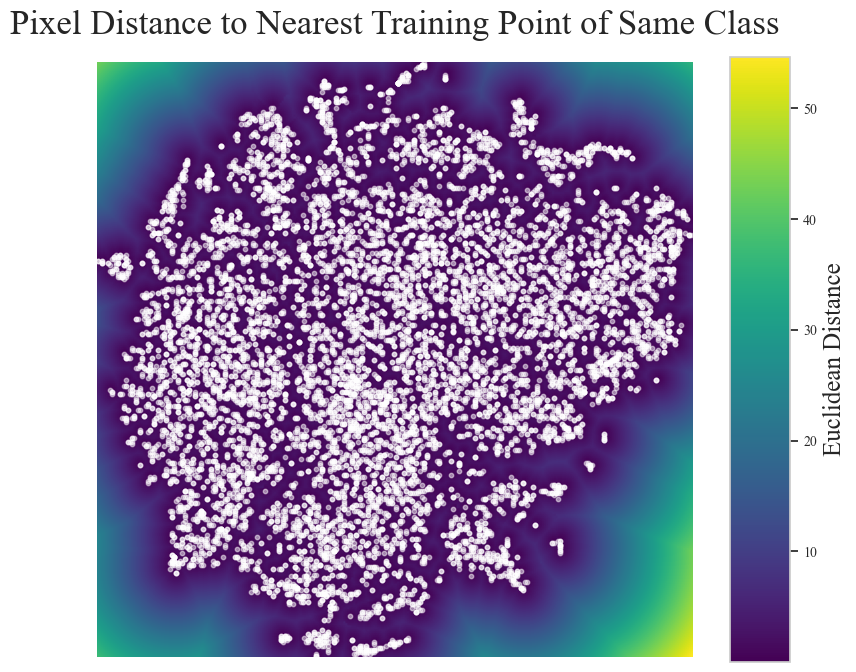

In [ ]:
pred_map.fit_grid_knn_weighted_interpolation(path=path)

In [88]:
pred_map.plot_original_data_points(path=path, grid_lines=False)

Plot saved as ../../../experiment_output/lamp/filtered_mnist_data_image_test\MLP_original_data_points.png.


In [89]:
pred_map.plot_data_with_predictions(path=path, grid_lines=False)

Plot saved as ../../../experiment_output/lamp/filtered_mnist_data_image_test\MLP_predicted_points.png.


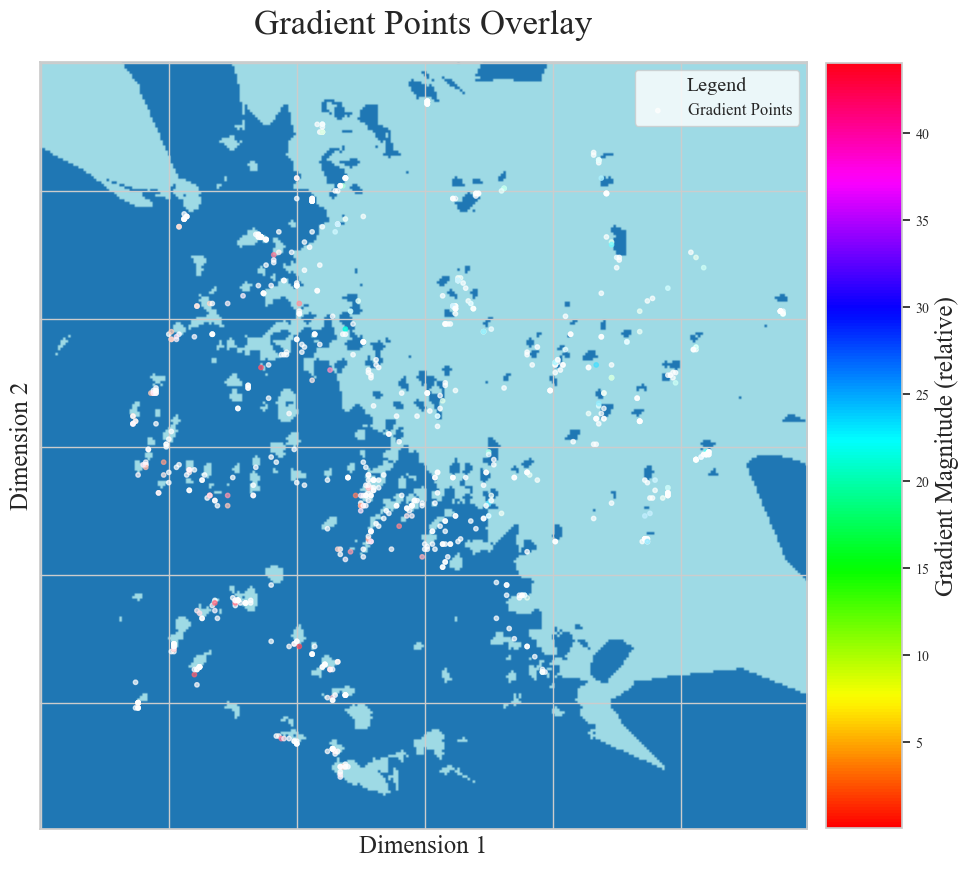

In [90]:
pred_map.plot_gradient(path=path)

1/1 [==============================] - 0s 33ms/step


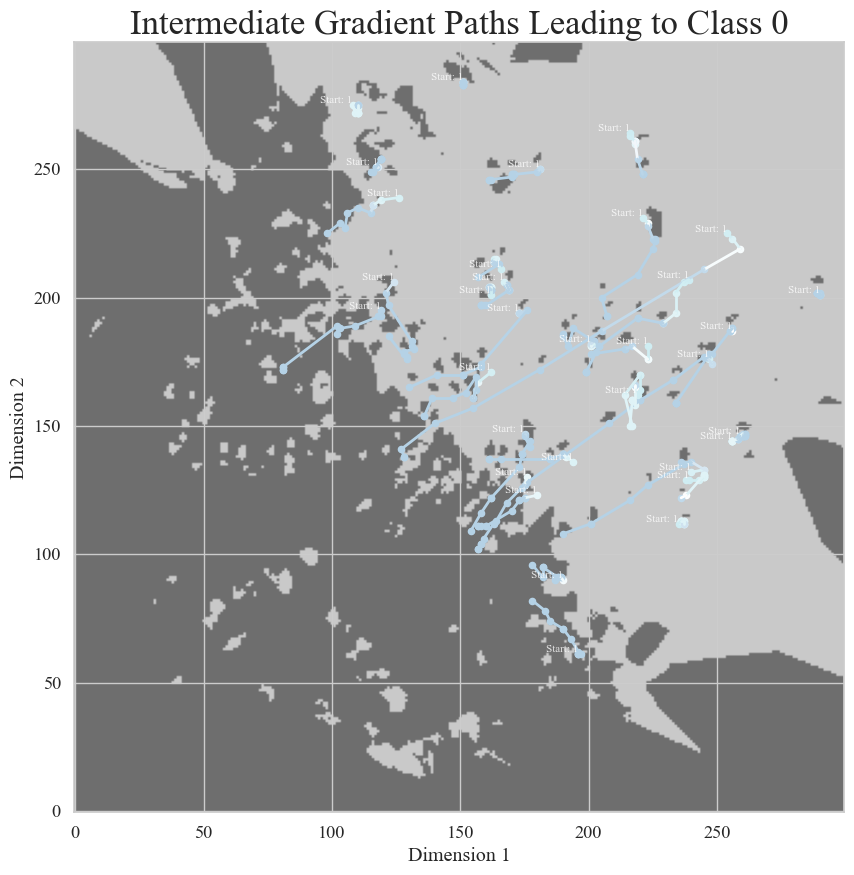

Class 0 paths overlay image saved as '../../../experiment_output/lamp/filtered_mnist_data_image_test\class_0_paths_overlay_MLP.png'.
1/1 [==============================] - 0s 31ms/step


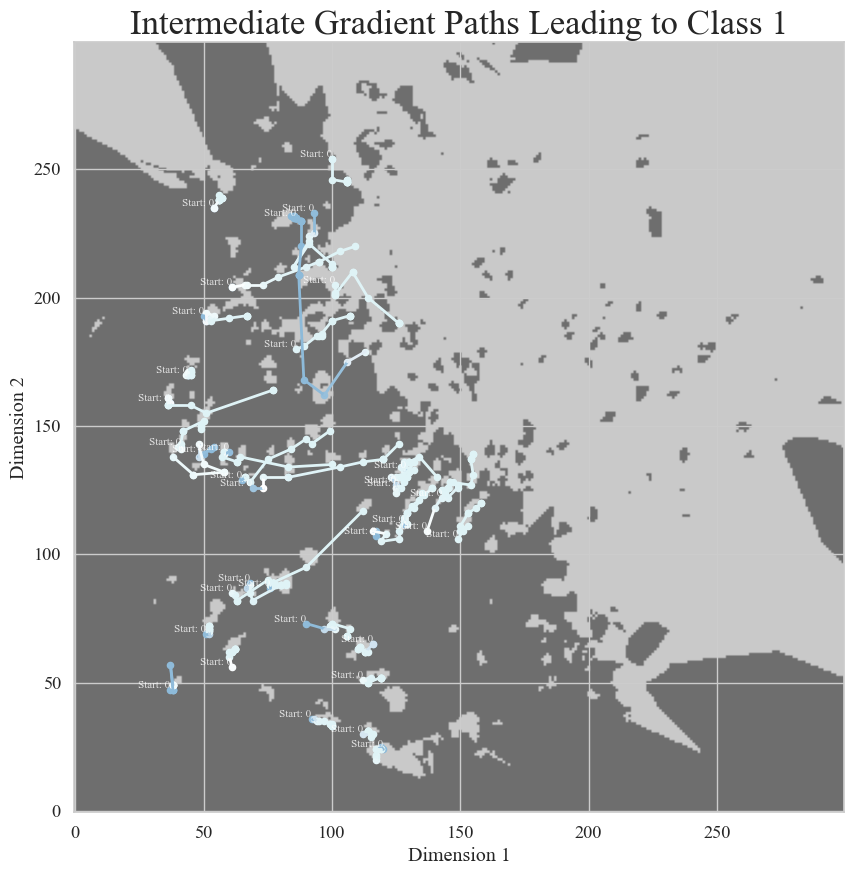

Class 1 paths overlay image saved as '../../../experiment_output/lamp/filtered_mnist_data_image_test\class_1_paths_overlay_MLP.png'.


In [91]:
for i in range(2):
    pred_map.plot_class_paths(target_class=i, paths_dict=class_paths, path=path)

In [92]:
high_dim_points = pd.read_csv(os.path.join(path, 'MLP_estimated_high_dim_points.csv'))

In [99]:
high_dim_points_path = high_dim_points.iloc[30160:30201]

In [100]:
high_dim_points_path

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
30160  0.363635  0.274878  0.331700  0.142102  0.302279  0.463090  0.580257   
30161  0.380668  0.281066  0.337796  0.166838  0.312807  0.493552  0.589265   
30162  0.384339  0.283587  0.342976  0.171273  0.307865  0.493744  0.587116   
30163  0.364636  0.263646  0.392711  0.156689  0.332130  0.428491  0.532039   
30164  0.353460  0.283923  0.383330  0.151654  0.311726  0.452962  0.531660   
30165  0.331236  0.335646  0.355999  0.141950  0.296511  0.484481  0.554860   
30166  0.330046  0.328404  0.362724  0.174146  0.275953  0.486534  0.555603   
30167  0.313851  0.331918  0.368981  0.195632  0.294488  0.480040  0.549562   
30168  0.313913  0.332273  0.368652  0.194076  0.295420  0.479937  0.549589   
30169  0.314025  0.332646  0.368287  0.192445  0.296097  0.479830  0.549868   
30170  0.413722  0.323839  0.338645  0.214583  0.316422  0.399130  0.455554   
30171  0.415021  0.324252  0.339003  0.212808  0.314716  0.399750  0.454855   
30172  0.414671  0.324185  0.338861  0.213343  0.315062  0.399611  0.455014   
30173  0.411714  0.323297  0.337993  0.217446  0.318809  0.398233  0.456570   
30174  0.409781  0.322672  0.337471  0.220073  0.321374  0.397305  0.457617   
30175  0.382489  0.325771  0.333542  0.229229  0.356527  0.367744  0.394597   
30176  0.464480  0.293946  0.388070  0.239677  0.315939  0.386352  0.447085   
30177  0.477658  0.291280  0.394223  0.235179  0.302709  0.399415  0.462640   
30178  0.489092  0.288967  0.399561  0.231275  0.291230  0.410749  0.476135   
30179  0.505995  0.286121  0.408413  0.225962  0.272807  0.428887  0.496359   
30180  0.505328  0.286770  0.408962  0.226599  0.272173  0.429465  0.495816   
30181  0.440446  0.283468  0.393877  0.259984  0.281385  0.467342  0.492136   
30182  0.438254  0.283165  0.393169  0.261029  0.281901  0.468568  0.492154   
30183  0.431467  0.282223  0.390978  0.264264  0.283500  0.472366  0.492209   
30184  0.422791  0.298853  0.368970  0.320423  0.331726  0.514371  0.488826   
30185  0.428240  0.313710  0.358249  0.398235  0.353704  0.559855  0.484076   
30186  0.430886  0.314631  0.358592  0.399493  0.354165  0.559963  0.483895   
30187  0.408100  0.346068  0.341578  0.449749  0.300900  0.298827  0.355547   
30188  0.408296  0.345915  0.340775  0.450146  0.300629  0.298809  0.355457   
30189  0.408598  0.345685  0.339558  0.450738  0.300218  0.298778  0.355329   
30190  0.408689  0.345678  0.339384  0.450721  0.300151  0.298732  0.355394   
30191  0.405593  0.348135  0.352184  0.444337  0.304457  0.298998  0.356877   
30192  0.405515  0.348096  0.352194  0.444488  0.304475  0.299063  0.356749   
30193  0.406177  0.347577  0.349479  0.445833  0.303561  0.299002  0.356443   
30194  0.406528  0.347303  0.348040  0.446544  0.303076  0.298970  0.356281   
30195  0.406730  0.347145  0.347213  0.446953  0.302797  0.298951  0.356188   
30196  0.481429  0.365024  0.420711  0.520749  0.234358  0.374292  0.406927   
30197  0.601626  0.288393  0.440242  0.614558  0.130777  0.581495  0.523104   
30198  0.555212  0.232840  0.394234  0.549590  0.184639  0.592413  0.553747   
30199  0.591785  0.236170  0.381761  0.543370  0.171178  0.594483  0.524688   
30200  0.591725  0.236069  0.382293  0.543463  0.170822  0.594580  0.525096   

            PC8       PC9      PC10  ...     PC164     PC165     PC166  \
30160  0.329119  0.230344  0.463408  ...  0.447980  0.460375  0.483119   
30161  0.302719  0.216015  0.464399  ...  0.429966  0.449553  0.486005   
30162  0.298500  0.213479  0.465738  ...  0.430320  0.449044  0.483686   
30163  0.349329  0.231289  0.412577  ...  0.427207  0.444057  0.460223   
30164  0.342418  0.234629  0.417978  ...  0.419139  0.434915  0.485452   
30165  0.330577  0.239206  0.423889  ...  0.408742  0.436410  0.479825   
30166  0.319762  0.232585  0.424355  ...  0.420661  0.445712  0.494325   
30167  0.327986  0.234296  0.418117  ...  0.430385  0.469099  0.482322   
30168  0.328482  0.234596  

(173,)


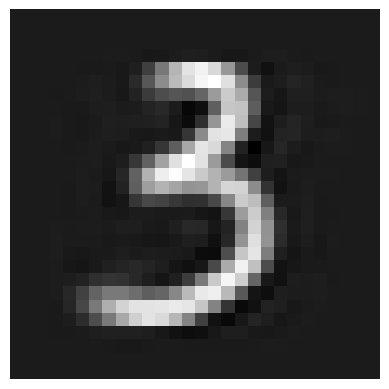

(173,)


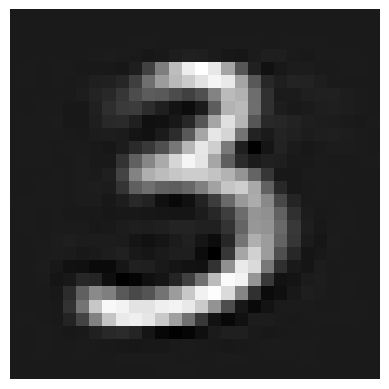

(173,)


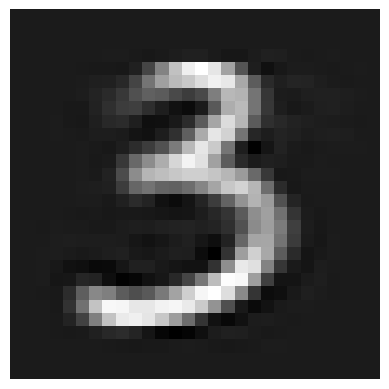

(173,)


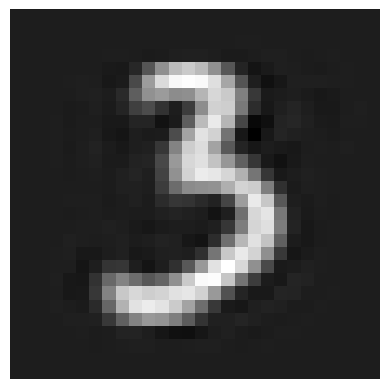

(173,)


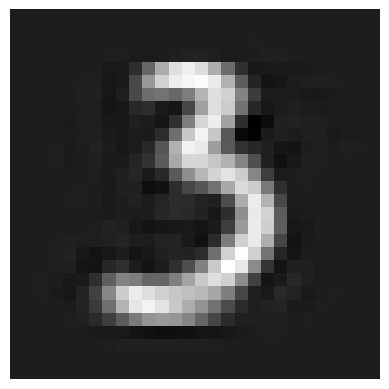

(173,)


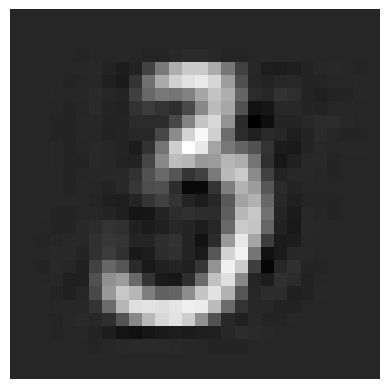

(173,)


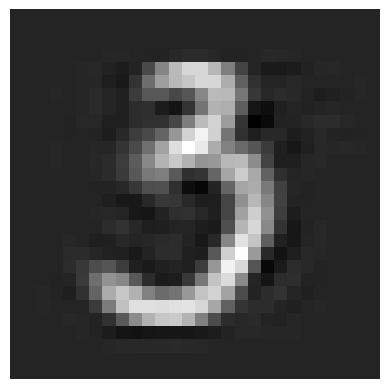

(173,)


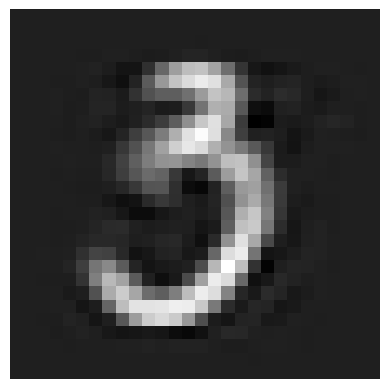

(173,)


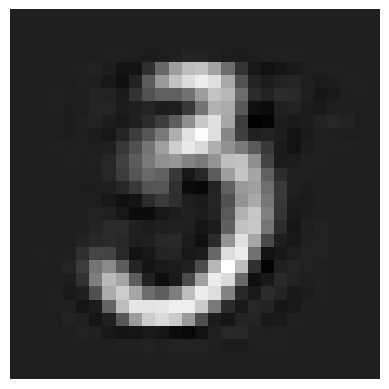

(173,)


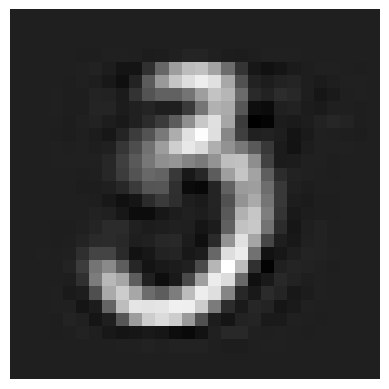

(173,)


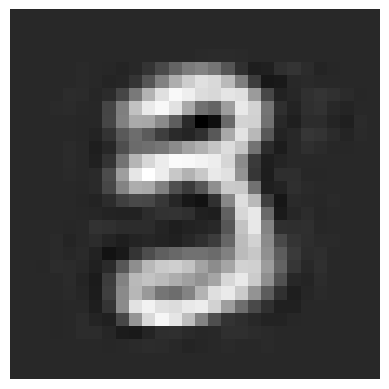

(173,)


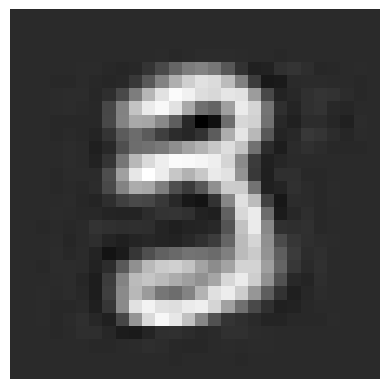

(173,)


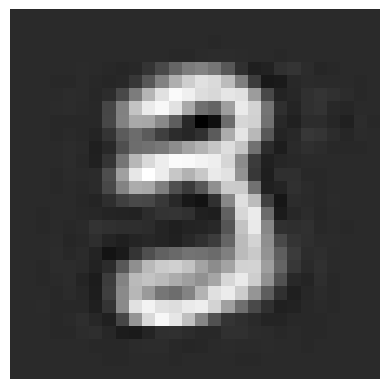

(173,)


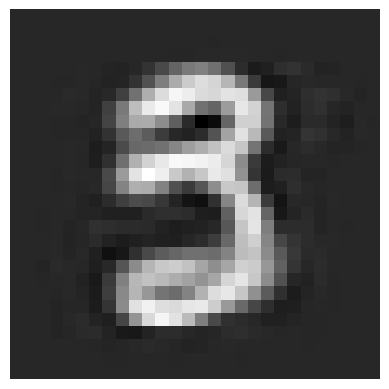

(173,)


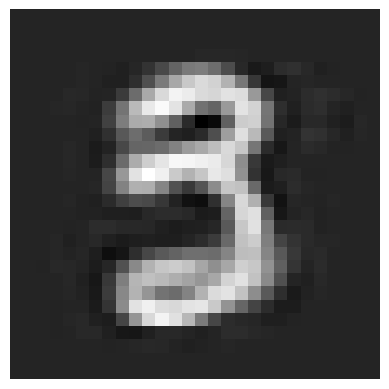

(173,)


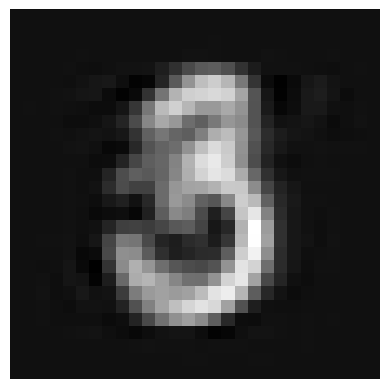

(173,)


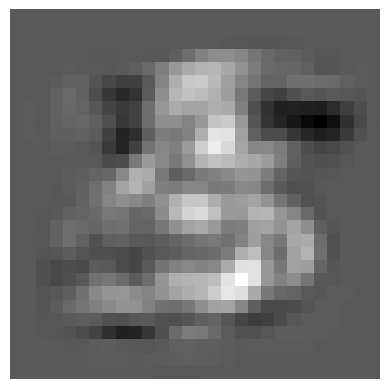

(173,)


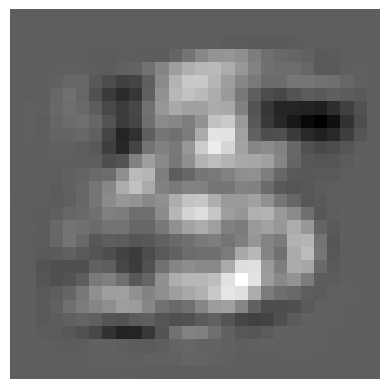

(173,)


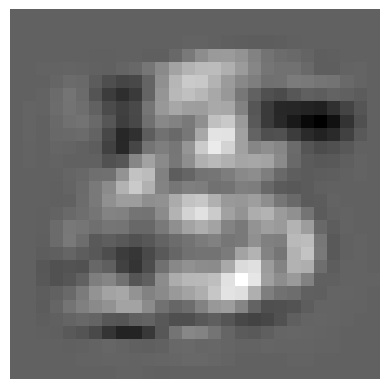

(173,)


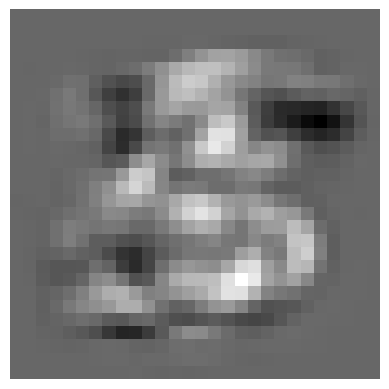

(173,)


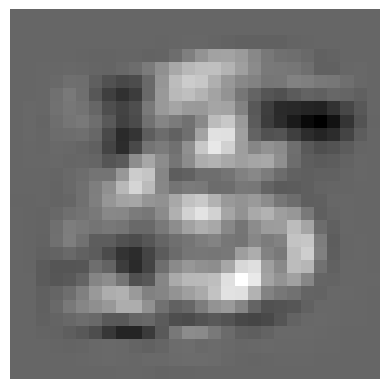

(173,)


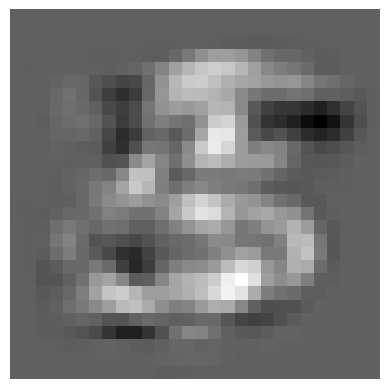

(173,)


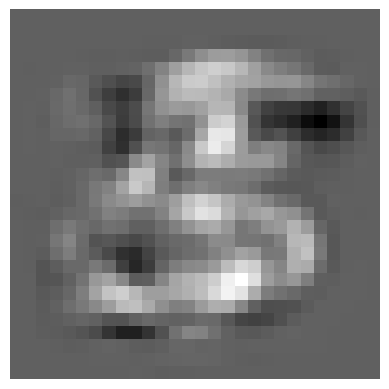

(173,)


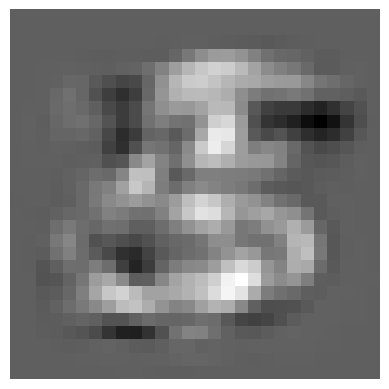

(173,)


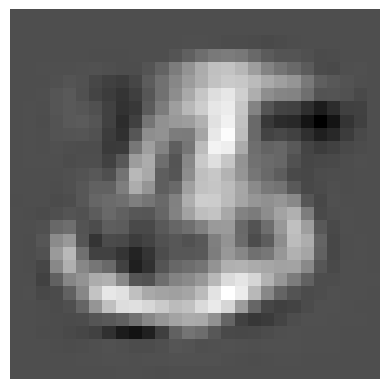

(173,)


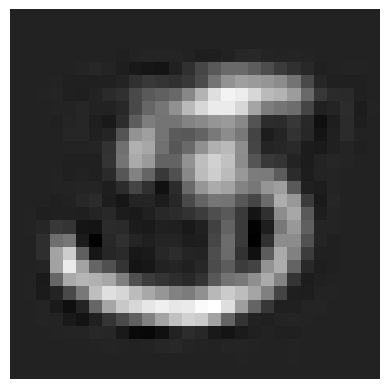

(173,)


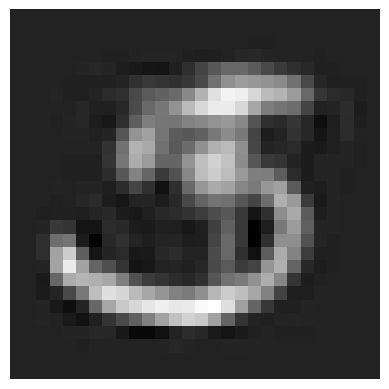

(173,)


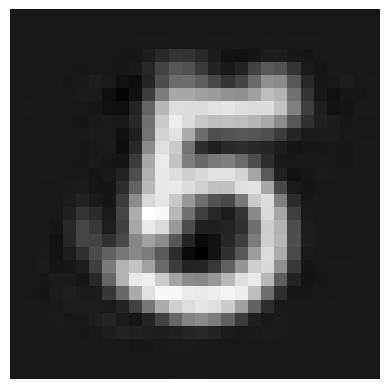

(173,)


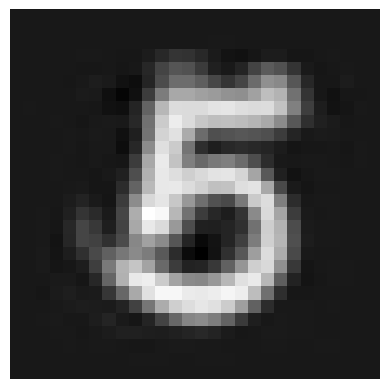

(173,)


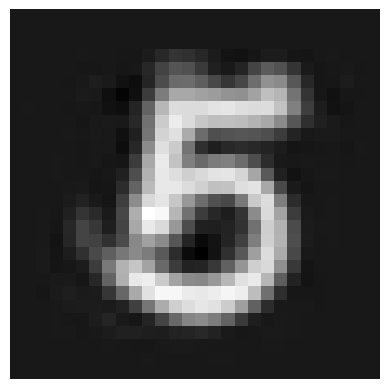

(173,)


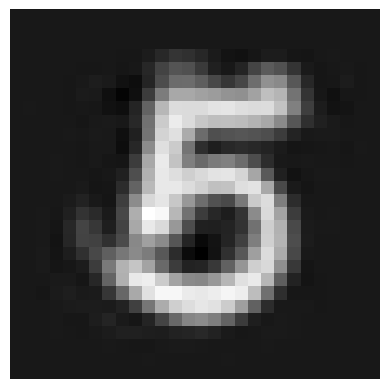

(173,)


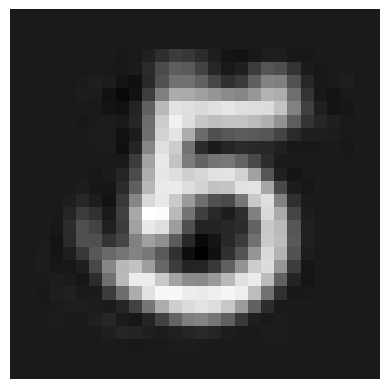

(173,)


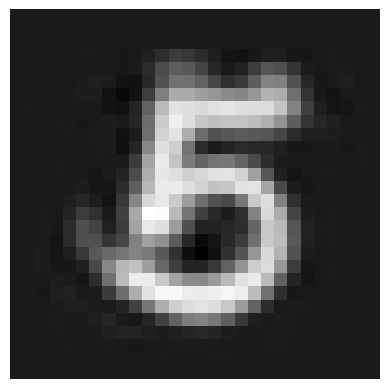

(173,)


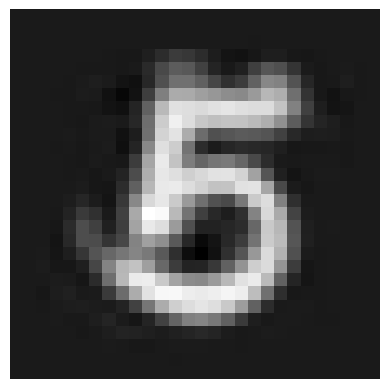

(173,)


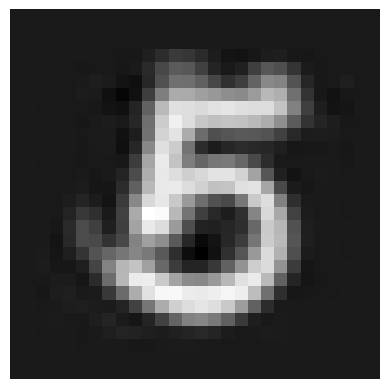

(173,)


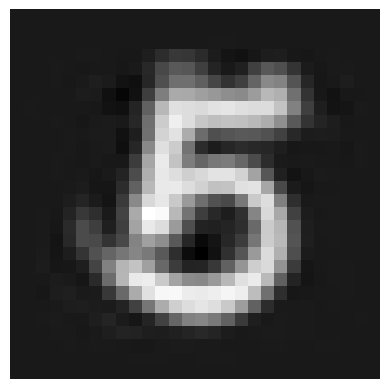

(173,)


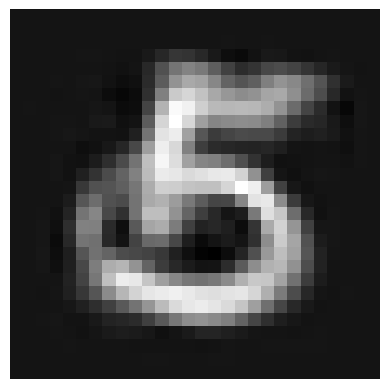

(173,)


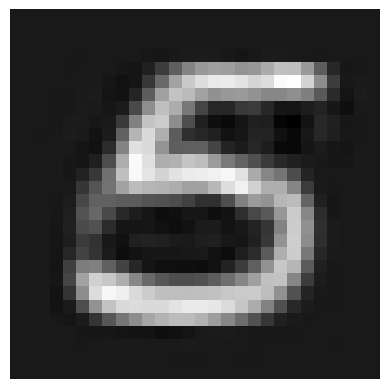

(173,)


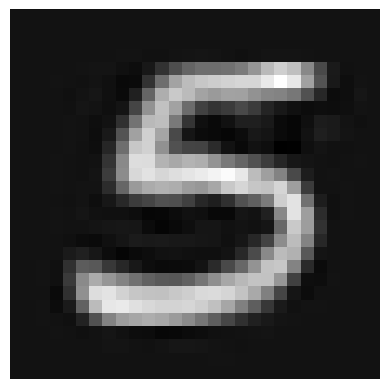

(173,)


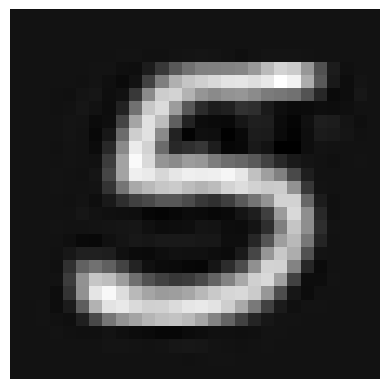

(173,)


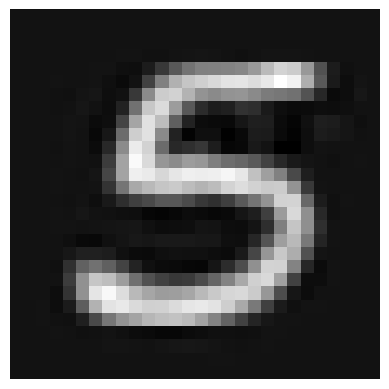

In [101]:
for x in high_dim_points_path.values:
    print(x.shape)
    pca_data = scaler_minmax.inverse_transform(x.reshape(1, 173))
    # shape: (1, n_components) => the raw PCA space

    std_data = pca.inverse_transform(pca_data)
    # shape: (1, 784) => now in standard-scaled space

    original_data = scaler_standard.inverse_transform(std_data)
    
    plt.imshow(original_data.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

In [102]:
high_dim_points = pd.read_csv(os.path.join(path, 'high_dim_data_MLP.csv'))

In [111]:
high_dim_points_path = high_dim_points.iloc[30180:30250]

(173,)


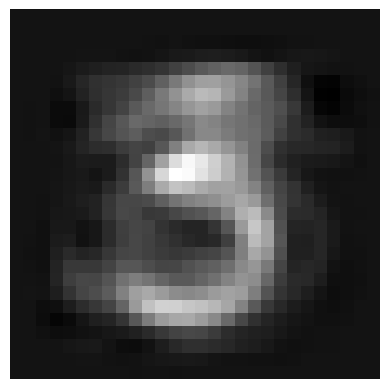

(173,)


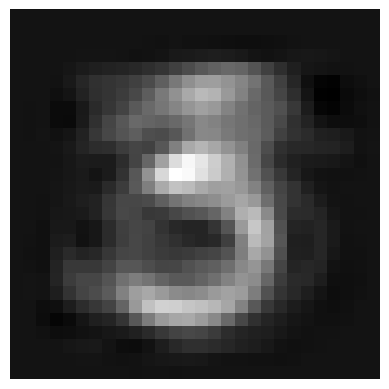

(173,)


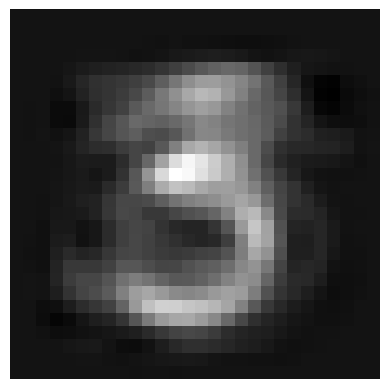

(173,)


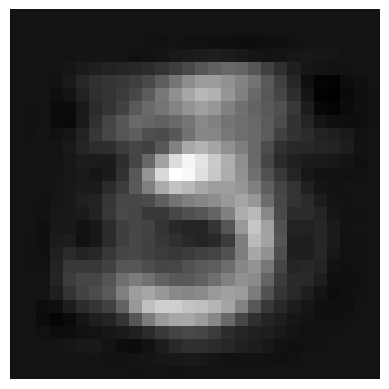

(173,)


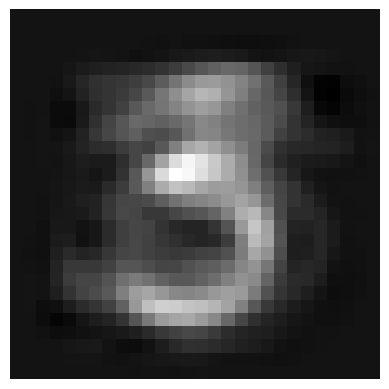

(173,)


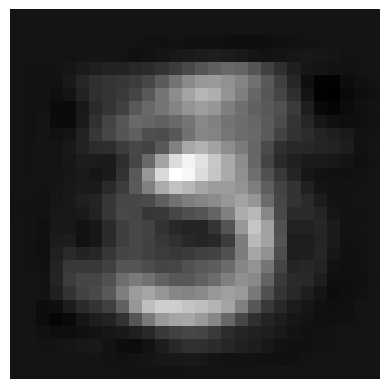

(173,)


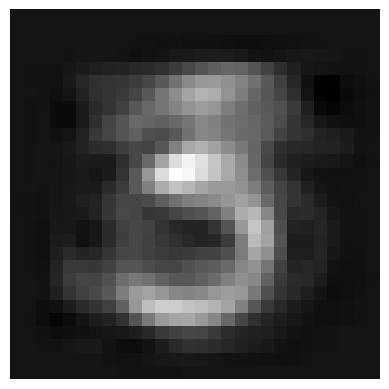

(173,)


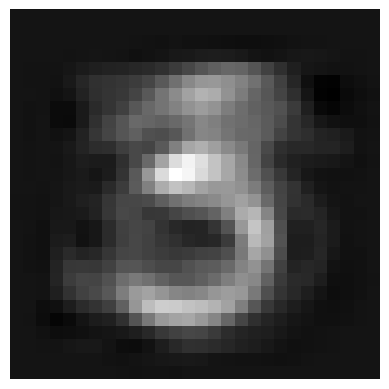

(173,)


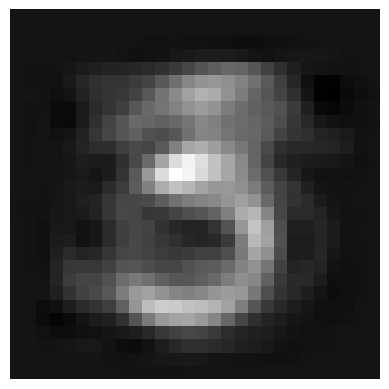

(173,)


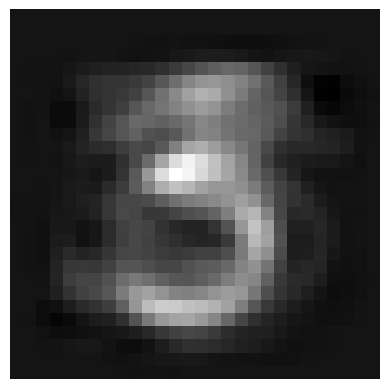

(173,)


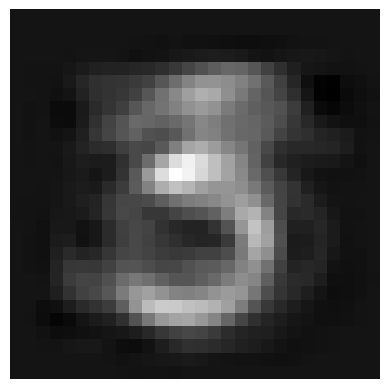

(173,)


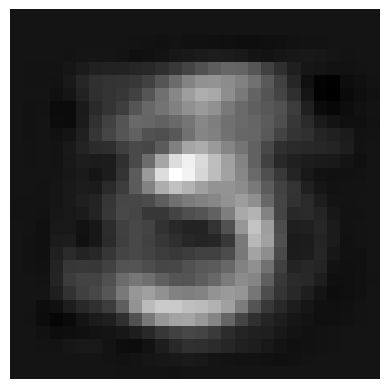

(173,)


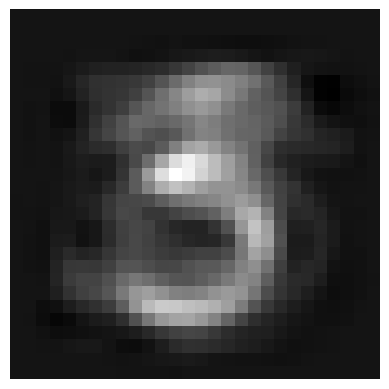

(173,)


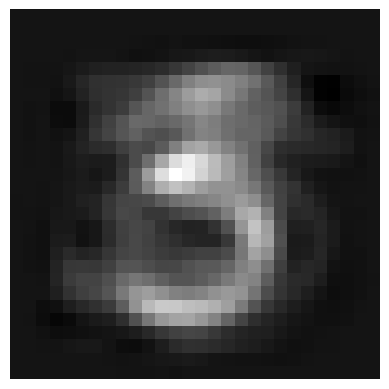

(173,)


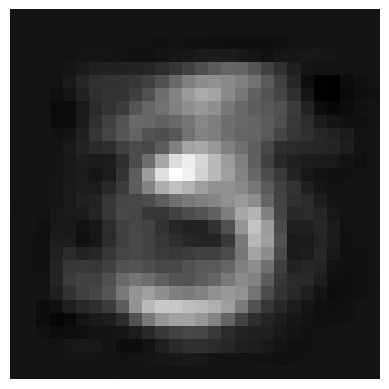

(173,)


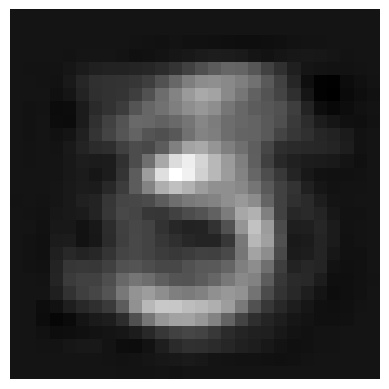

(173,)


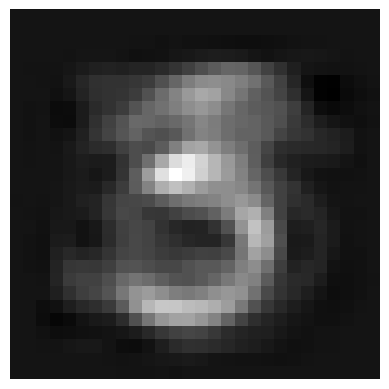

(173,)


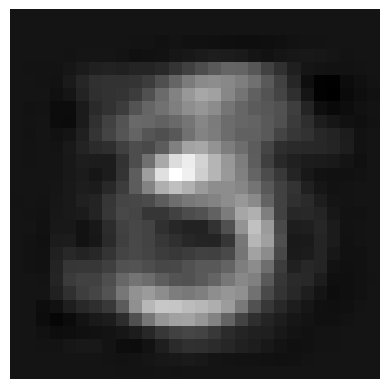

(173,)


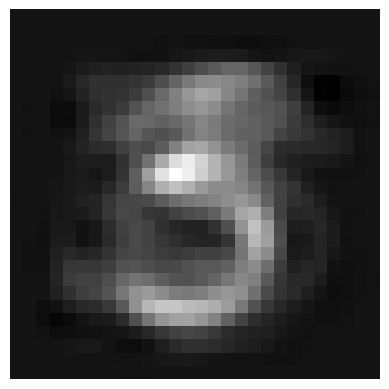

(173,)


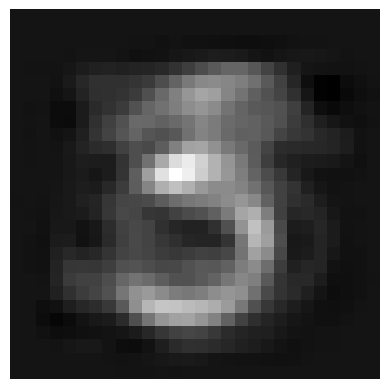

(173,)


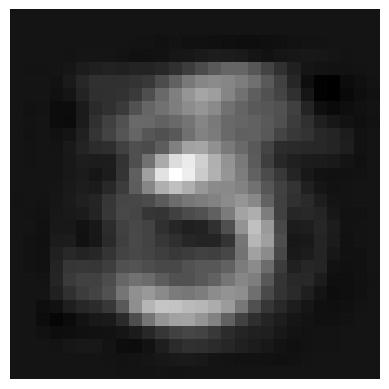

(173,)


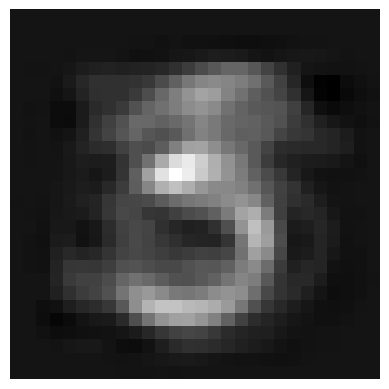

(173,)


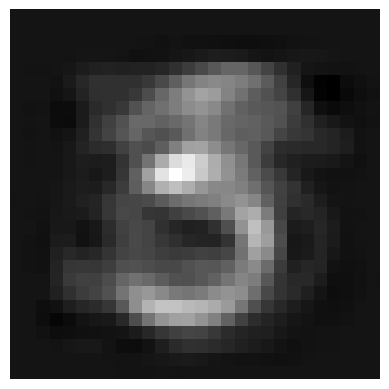

(173,)


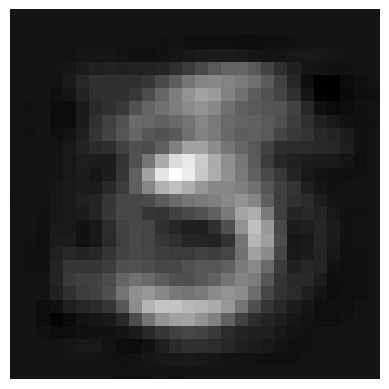

(173,)


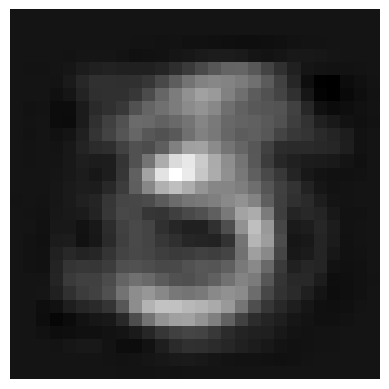

(173,)


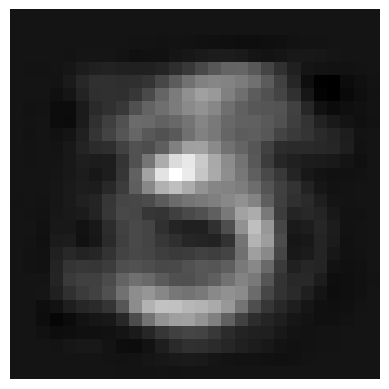

(173,)


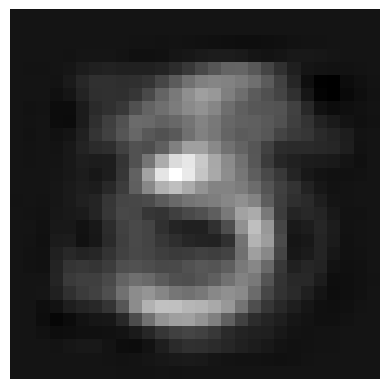

(173,)


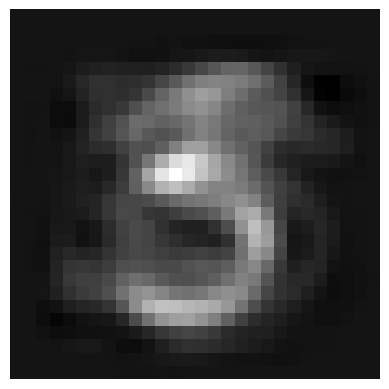

(173,)


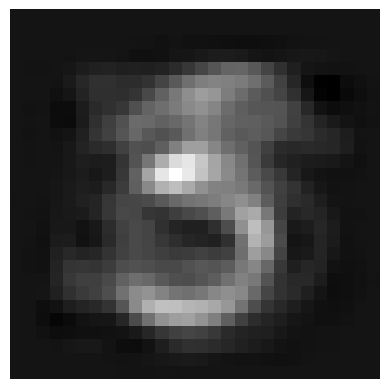

(173,)


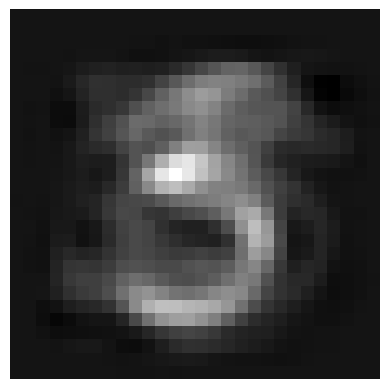

(173,)


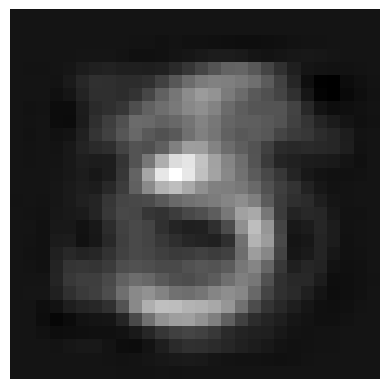

(173,)


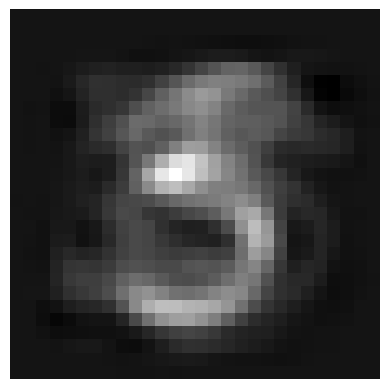

(173,)


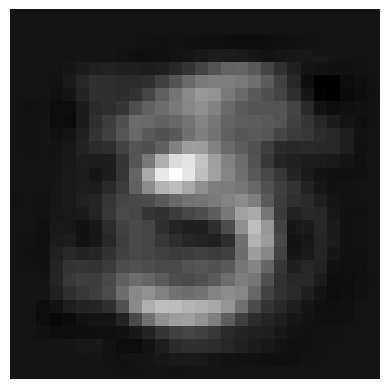

(173,)


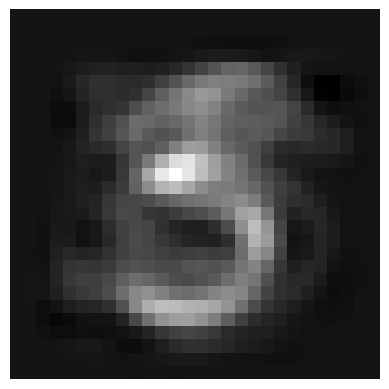

(173,)


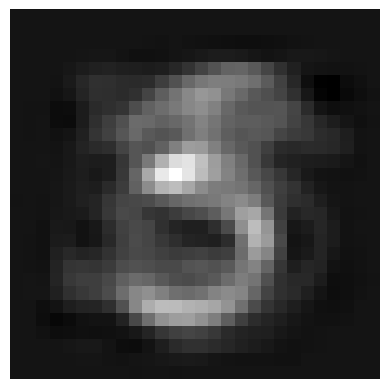

(173,)


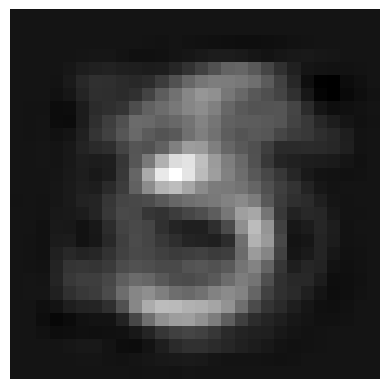

(173,)


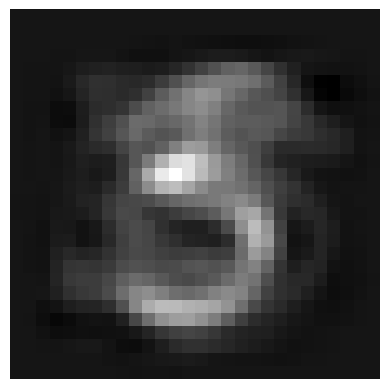

(173,)


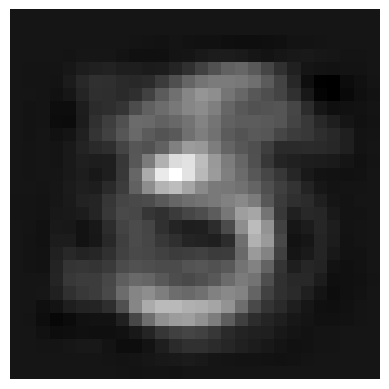

(173,)


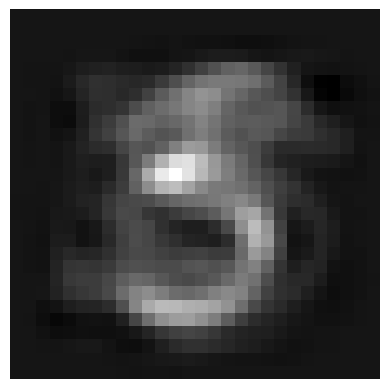

(173,)


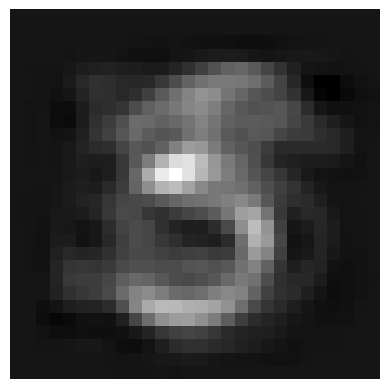

(173,)


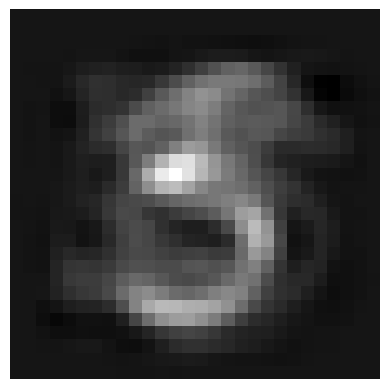

(173,)


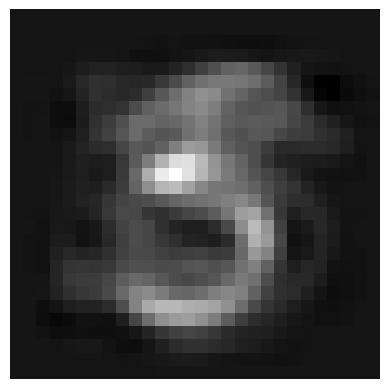

(173,)


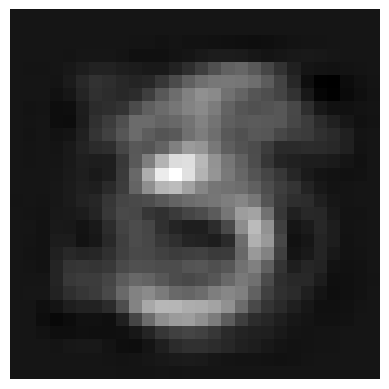

(173,)


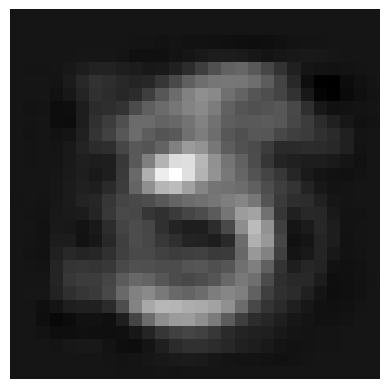

(173,)


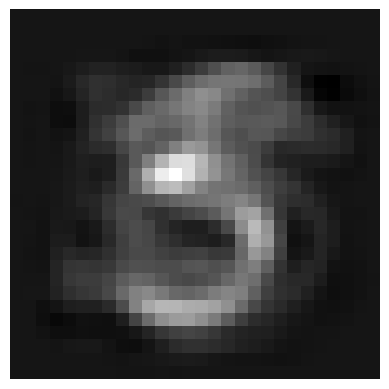

(173,)


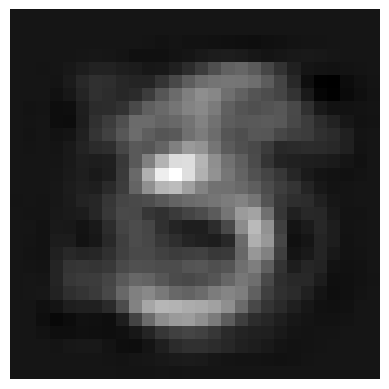

(173,)


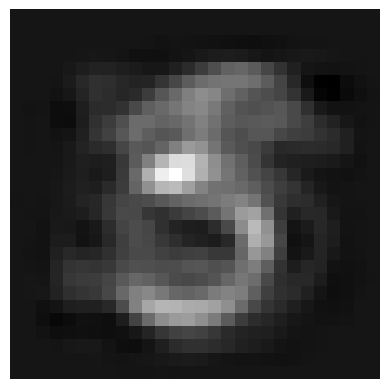

(173,)


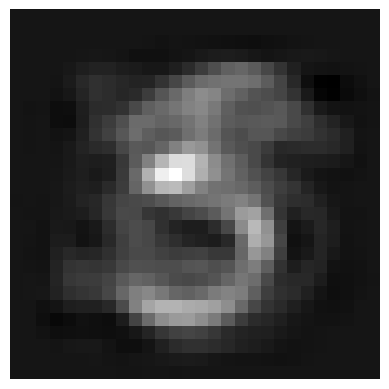

(173,)


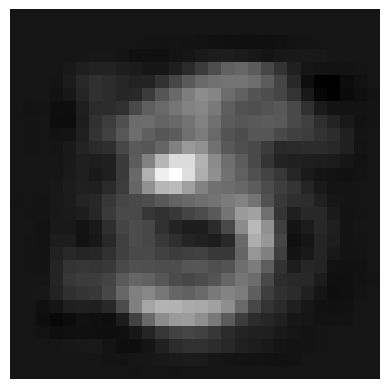

(173,)


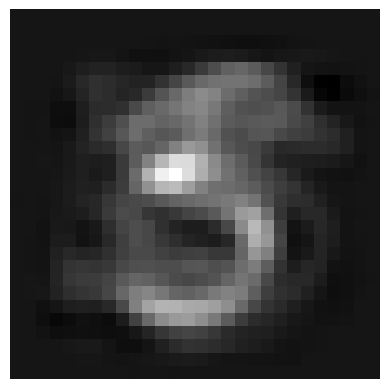

(173,)


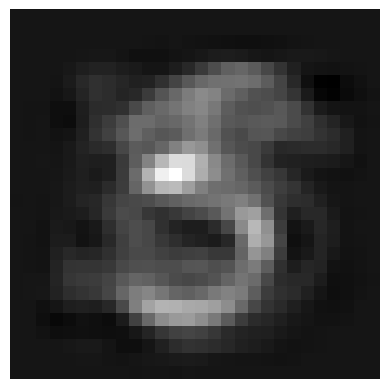

(173,)


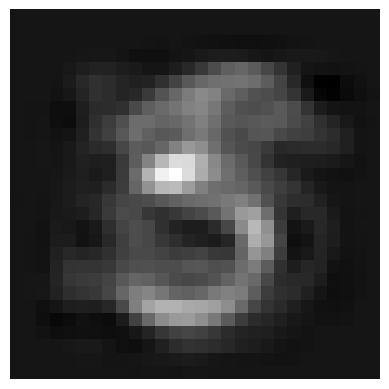

(173,)


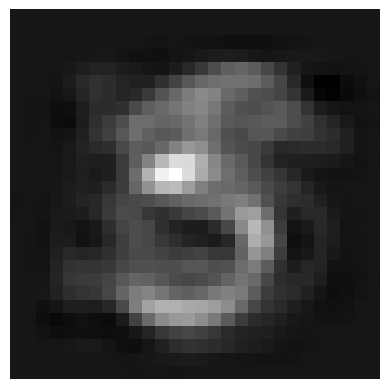

(173,)


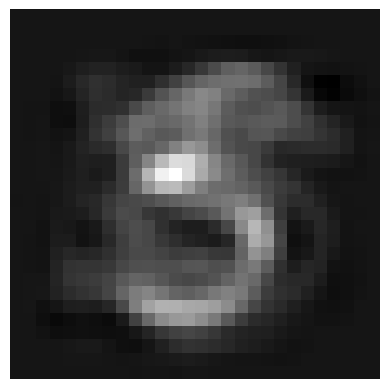

(173,)


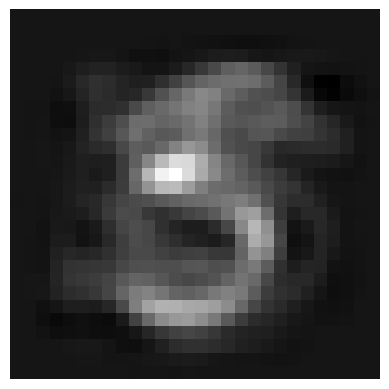

(173,)


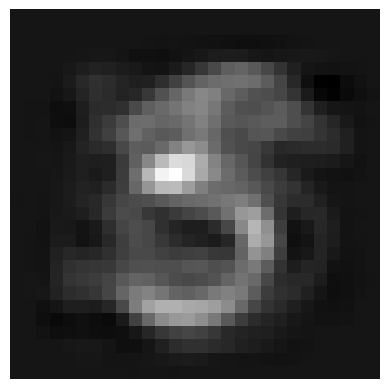

(173,)


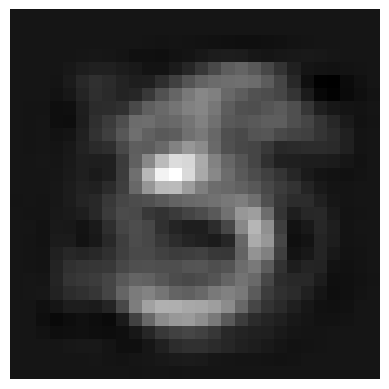

(173,)


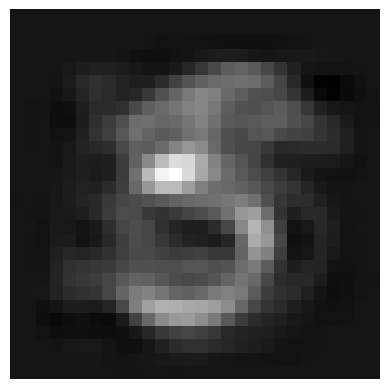

(173,)


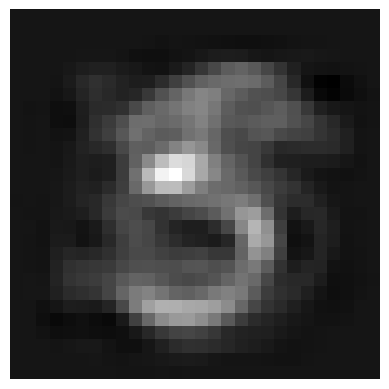

(173,)


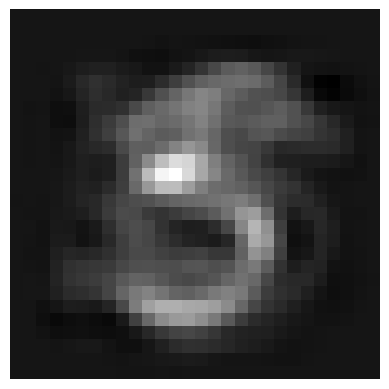

(173,)


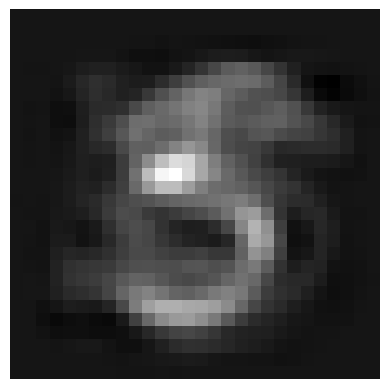

(173,)


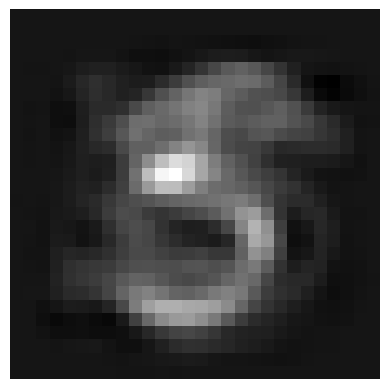

(173,)


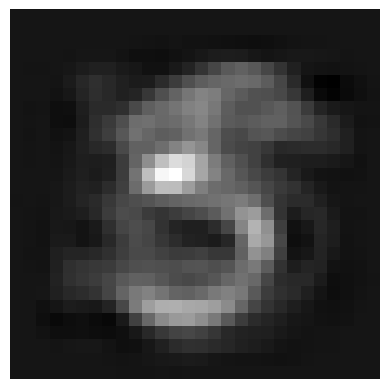

(173,)


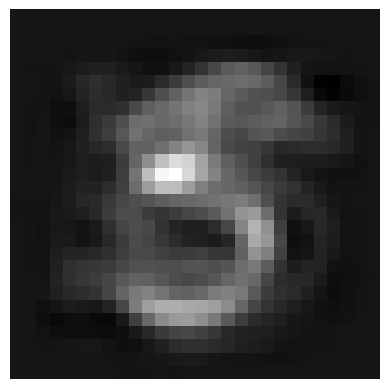

(173,)


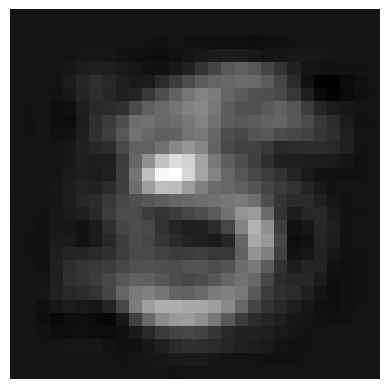

(173,)


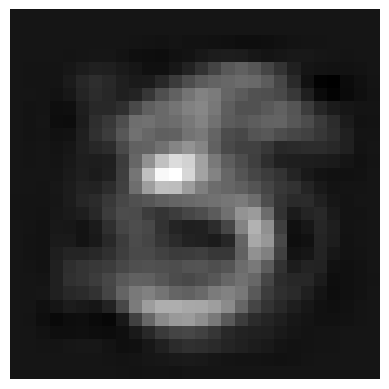

(173,)


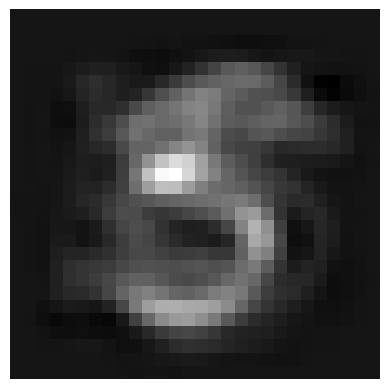

(173,)


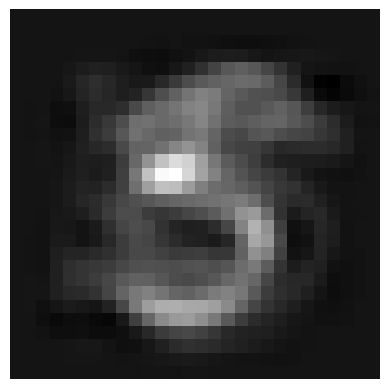

(173,)


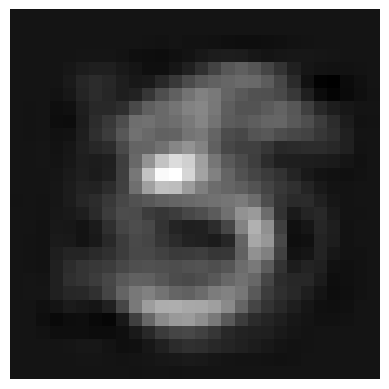

(173,)


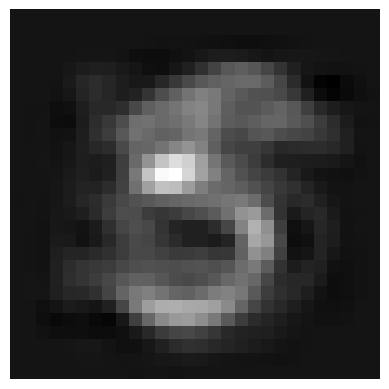

In [112]:
for x in high_dim_points_path.values:
    print(x.shape)
    pca_data = scaler_minmax.inverse_transform(x.reshape(1, 173))
    # shape: (1, n_components) => the raw PCA space

    std_data = pca.inverse_transform(pca_data)
    # shape: (1, 784) => now in standard-scaled space

    original_data = scaler_standard.inverse_transform(std_data)
    
    plt.imshow(original_data.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

In [114]:
transformation = class_paths[0]['paths'][1]
print(transformation)

[1, [array([[0.25230542, 0.37995276, 0.24679832, 0.42878458, 0.16804963,
        0.41672066, 0.5022655 , 0.3862453 , 0.26985553, 0.483209  ,
        0.07810842, 0.2303882 , 0.38125807, 0.40583608, 0.17592828,
        0.3910562 , 0.33676   , 0.31708097, 0.45933187, 0.47211075,
        0.48708525, 0.14898811, 0.29491335, 0.06747162, 0.16821831,
        0.22004956, 0.5098948 , 0.26146615, 0.4803235 , 0.35548142,
        0.33475128, 0.5138183 , 0.33339185, 0.44199875, 0.3075564 ,
        0.458508  , 0.33250183, 0.45525077, 0.43259308, 0.3466813 ,
        0.35479993, 0.39719135, 0.31423694, 0.32971978, 0.4424129 ,
        0.31222087, 0.5385164 , 0.4184596 , 0.3366537 , 0.37277645,
        0.40949494, 0.52223116, 0.3457056 , 0.427925  , 0.24588476,
        0.284282  , 0.5402157 , 0.403137  , 0.22005293, 0.497064  ,
        0.43829903, 0.38852915, 0.41853765, 0.46249548, 0.4772964 ,
        0.4002684 , 0.2944197 , 0.44459292, 0.36961046, 0.335581  ,
        0.3764595 , 0.22333781, 0.37549335,

(1, 1, 173)


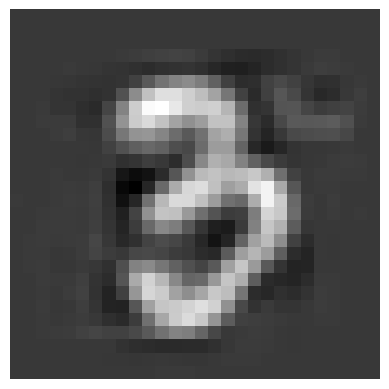

(1, 1, 173)


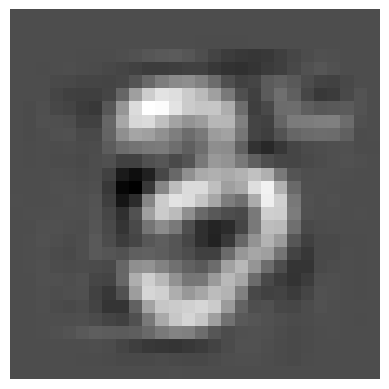

(1, 1, 173)


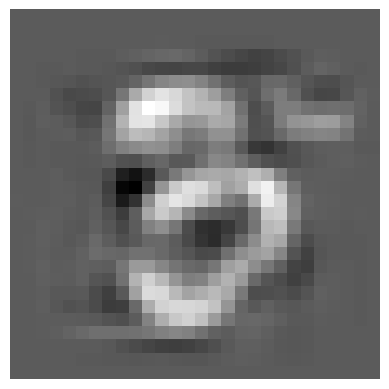

(1, 1, 173)


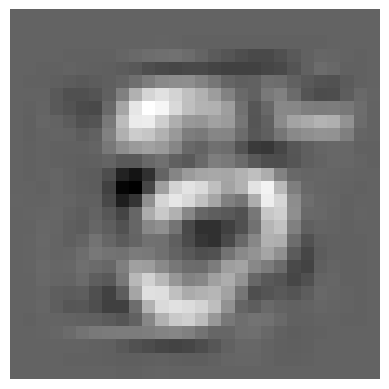

(1, 1, 173)


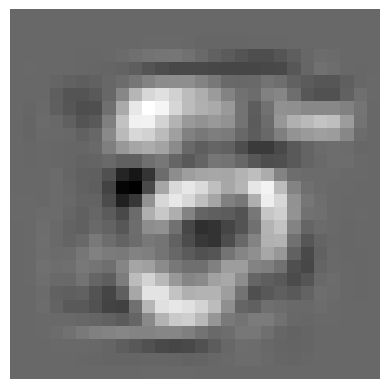

(1, 1, 173)


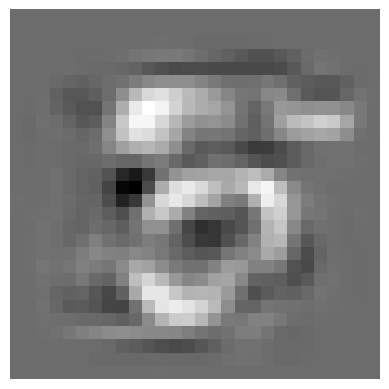

(1, 1, 173)


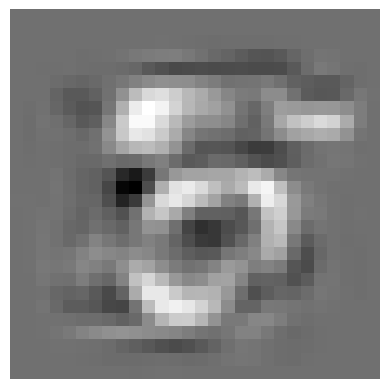

(1, 1, 173)


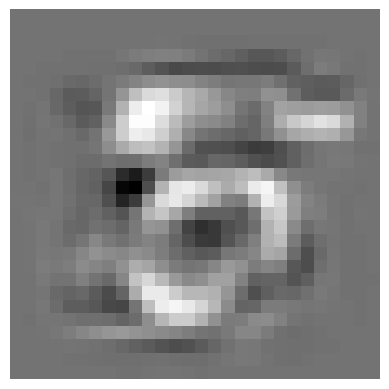

(1, 1, 173)


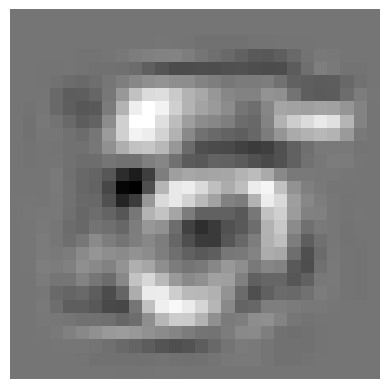

(1, 1, 173)


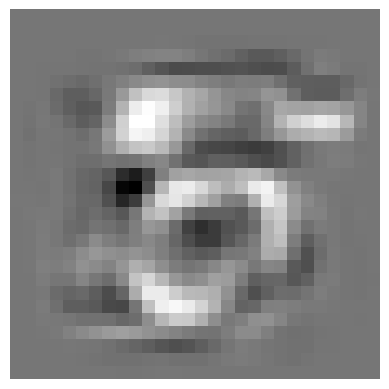

(1, 1, 173)


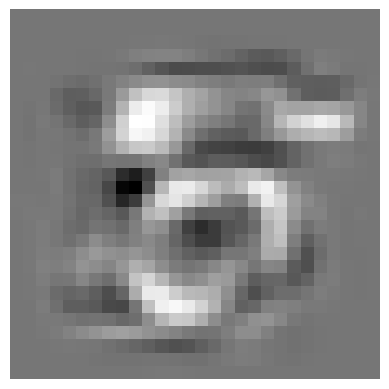

In [115]:
#From 0 to 1
transformation = np.array(class_paths[1]['paths'][1][1:])

for x in transformation:
    print(x.shape)
    pca_data = scaler_minmax.inverse_transform(x.reshape(1, 173))
    # shape: (1, n_components) => the raw PCA space

    std_data = pca.inverse_transform(pca_data)
    # shape: (1, 784) => now in standard-scaled space

    original_data = scaler_standard.inverse_transform(std_data)
    
    plt.imshow(original_data.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
intermediate_data = pd.read_csv('../../../experiment_output/lamp/reduced_mnist_data_image_test/1/intermediate_data.csv')

Randomly selected features: ['125', '90', '79', '19', '126', '30', '77', '93', '68', '80']
Scatterplot matrix saved to scatterplots


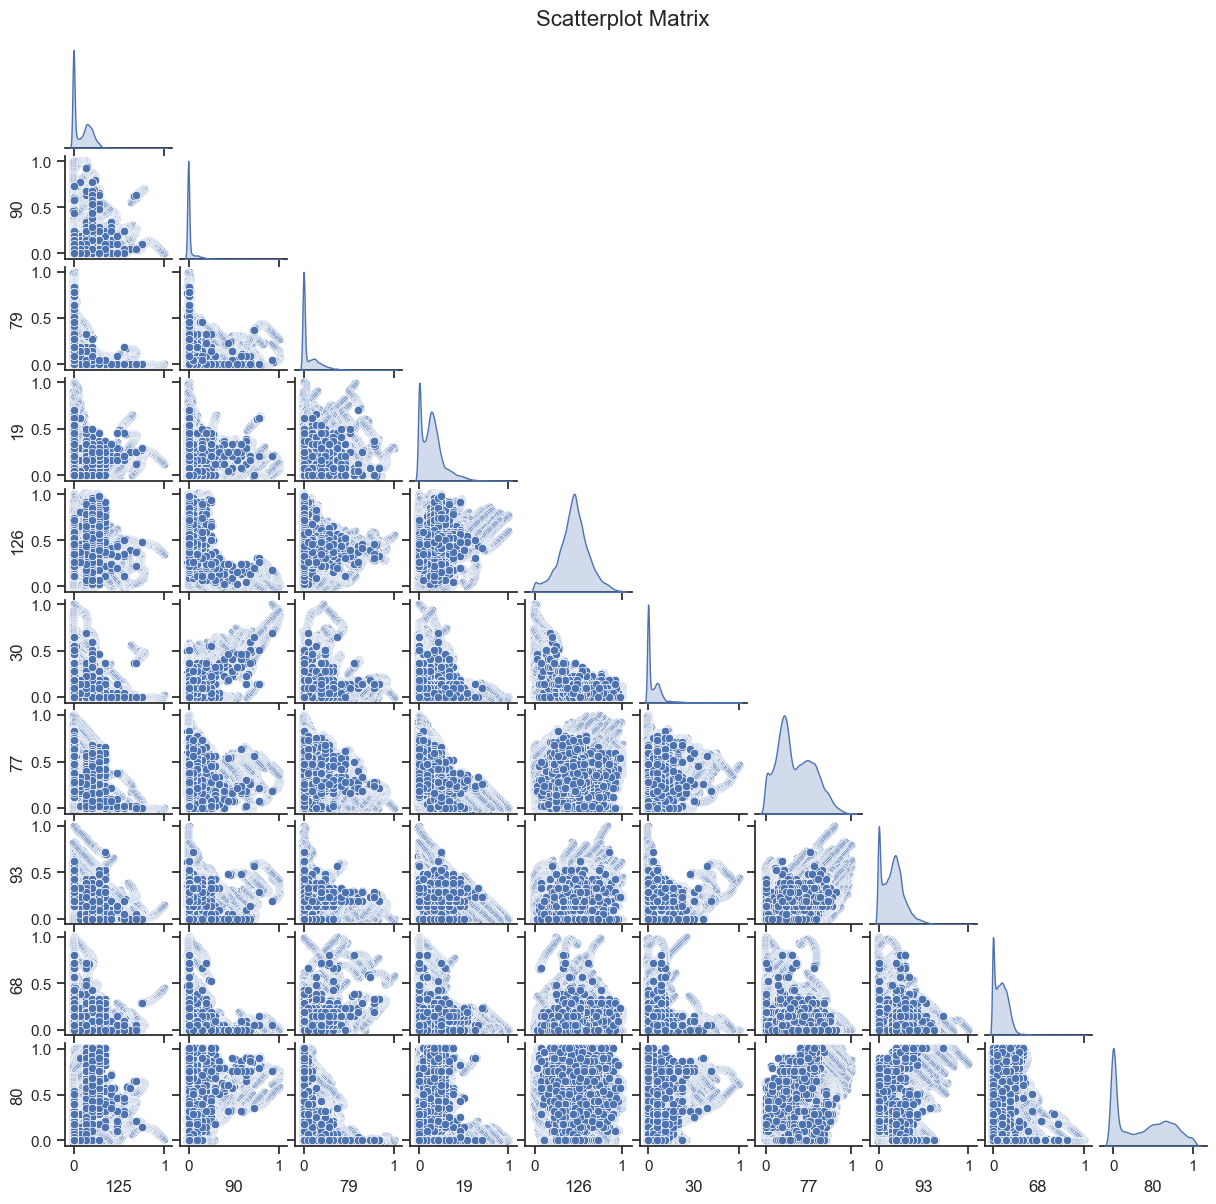

In [37]:
#Scatterplots

from plots import *

#Scatterplot for generated high-dimensional data
high_dim_intermediate = pd.read_csv('output/fmnist_test_features_restricted_intermediate_gradients.csv')
high_dim_intermediate['label'] = intermediate_y_pred_binary
high_dim_original = pd.read_csv('output/fmnist_test_features_restricted_original.csv')
high_dim_original['label'] = predictions_dataset_binary
high_dim_counterfactuals = pd.read_csv('output/fmnist_test_features_restricted_counterfactuals.csv')
high_dim_counterfactuals['label'] = cf_points_binary
combined_high_dim_data = pd.concat([high_dim_original, high_dim_intermediate, high_dim_counterfactuals], axis=0)
combined_high_dim_data = combined_high_dim_data.reset_index(drop=True)
scatterplot_matrix(combined_high_dim_data, features=None, hue=None, save_path='scatterplots', figsize=(12, 12), random_subset_size=10)

In [96]:
X = all_gradients.values

X_centered = X - X.mean(axis=0, keepdims=True)

# Compute SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# V is the transpose of Vt
V = Vt.T  # shape (d, d)

# Extract first two principal components
PC1 = V[:, 0]  # first principal component
PC2 = V[:, 1]  # second principal component

# Project data onto the first two principal components
T = X_centered @ V[:, :2]  # shape (n, 2)

In [101]:
def gradient_to_hsv(gX, gY):
    """
    Convert a gradient field represented by gX, gY into HSV colors.
    Hue corresponds to the direction (angle) of the gradient,
    Saturation corresponds to the magnitude (normalized),
    Value is fixed to 1.0.
    """
    angle = np.arctan2(gY, gX)
    # Normalize angle to [0,1]
    H = (angle + np.pi) / (2 * np.pi)
    # Compute magnitude and normalize
    magnitude = np.sqrt(gX**2 + gY**2)
    mag_max = magnitude.max() if magnitude.max() != 0 else 1
    S = magnitude / mag_max
    V = np.ones_like(H)
    hsv = np.stack((H, S, V), axis=-1)
    return hsv

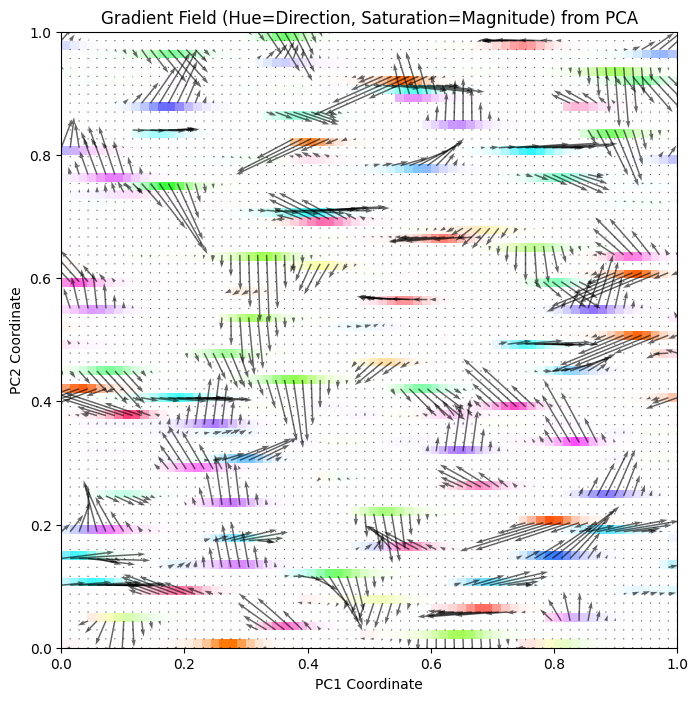

In [104]:
gX = T[:,0]
gY = T[:,1]

num_points = gX.shape[0]
grid_size = int(np.floor(np.sqrt(num_points)))

grid_count = grid_size**2
gX = gX[:grid_count].reshape(grid_size, grid_size)
gY = gY[:grid_count].reshape(grid_size, grid_size)

# 7. Convert to HSV using the gradient_to_hsv function
hsv = gradient_to_hsv(gX, gY)

# 8. Convert HSV to RGB for plotting
rgb = mcolors.hsv_to_rgb(hsv)

# Create coordinate grids (assuming a normalized coordinate system)
x_coords = np.linspace(0, 1, grid_size)
y_coords = np.linspace(0, 1, grid_size)
X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

# 9. Plot the result
plt.figure(figsize=(8, 8))
plt.imshow(rgb, origin='lower', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
plt.title('Gradient Field (Hue=Direction, Saturation=Magnitude) from PCA')
plt.xlabel('PC1 Coordinate')
plt.ylabel('PC2 Coordinate')

# Overlay quiver to show actual vectors
plt.quiver(X_grid, Y_grid, gX, gY, color='black', alpha=0.6)
plt.show()

In [ ]:
all_intermediate_points_gradient = all_intermediate_points_gradient.drop('label', axis=1) if 'label' in all_intermediate_points_gradient.columns else all_intermediate_points_gradient
cf_combined = cf_combined.drop('label', axis=1) if 'label' in cf_combined.columns else cf_combined
pred_map = create_map_UMAP_test_no_intermediate.PredictionMap(300, cf_combined, all_intermediate_points_gradient, 1, model_for_predictions, scaler, intermediate_y_pred, y_test_combined, version='no_intermediate')

In [ ]:
pred_map.fit_points_2D()

In [ ]:
pred_map.fit_grid_knn_weighted_interpolation(version='no_intermediate')